In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers                    

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/My Drive/Aerial"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/Aerial/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:int(len(files_all)/2)+1]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[int(len(files_all)/2):]:
  right_files_path.append(folder_path + file)

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())

2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.50, fy=0.50, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.50,fy=0.50, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


In [10]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 6.775331020355225 [s] ... size 1512.11264 MB


In [11]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 28.184478759765625 [s] ... size 2016.149504 MB


In [12]:
f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/all_images_bgr_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 25.63202476501465 [s] ... size 1512.11264 MB


In [13]:
f=h5.File('drive/MyDrive/all_images_gray_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/all_images_gray_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 32.608059883117676 [s] ... size 2016.149504 MB


In [14]:
del images_left_bgr,images_right_bgr

In [15]:

from timeit import default_timer as timer
time_all = []

In [16]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_freak = []
num_kps_gftt = []
num_kps_briefstar = []
num_kps_rootsift = []


In [17]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


In [18]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 39180.79it/s]


In [19]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [20]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [21]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [22]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [23]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [24]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

In [25]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [11:47<00:00, 14.16s/it]


In [26]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 252973.70it/s]


In [27]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [28]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [29]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [30]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [31]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [32]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

In [33]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [34]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:02<00:00,  2.45s/it]


In [35]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 92467.02it/s]


In [36]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [37]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [38]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [39]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [40]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [41]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right

In [42]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


In [43]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 390895.06it/s]


In [44]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [45]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [46]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [47]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [48]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [49]:
del Fdb, all_feat_orb_left, all_feat_orb_right

In [50]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


In [51]:
num_kps_star=[]
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 313007.76it/s]


In [52]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [53]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [54]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [55]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [56]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [57]:
del Fdb, all_feat_star_left, all_feat_star_right

In [58]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [59]:
num_kps_freak=[]
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 37847.90it/s]


In [60]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [61]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [62]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [63]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [64]:
del Fdb, all_feat_freak_left, all_feat_freak_right

In [65]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:32<00:00,  3.06s/it]


In [66]:
num_kps_agast=[]
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 117454.61it/s]


In [67]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [68]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [69]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [70]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [71]:
del Fdb, all_feat_agast_left

In [72]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [73]:
del Fdb, all_feat_agast_right

In [74]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [75]:
start = timer()
threshl=60;
sift = cv2.xfeatures2d.SIFT_create(threshl)
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


In [76]:
num_kps_rootsift=[]
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 288268.32it/s]


In [77]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [78]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [79]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [80]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [81]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [82]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

In [83]:
start = timer()
threshl=60;
gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create(threshl)

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


In [84]:
num_kps_gftt=[]
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 57788.70it/s]


In [85]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [86]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [87]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [88]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [89]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [90]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

In [91]:
start = timer()
threshl=60;
daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create(threshl)

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


In [92]:
num_kps_daisy=[]
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 293307.97it/s]


In [93]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [94]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [95]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [96]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [97]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [98]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

In [99]:
start = timer()
threshl=60;
sift = cv2.xfeatures2d.SIFT_create(threshl)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


In [100]:
num_kps_sift=[]
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 48884.66it/s]


In [101]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [102]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [103]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [104]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [105]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [106]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [107]:
start = timer()
threshl=60;
mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create(threshl)

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [08:05<00:00,  9.72s/it]


In [108]:
num_kps_mser=[]
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 28437.89it/s]


In [109]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [110]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [111]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [112]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [113]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [114]:
del Fdb, all_feat_mser_left, all_feat_mser_right

In [115]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [116]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [117]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [118]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [119]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [120]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [121]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/51 [00:02<01:50,  2.20s/it]


Number of matches 29049
Number of matches After Lowe's Ratio 496
Number of Robust matches 208




  4%|▍         | 2/51 [00:04<01:54,  2.34s/it]


Number of matches 14540
Number of matches After Lowe's Ratio 42
Number of Robust matches 22


Number of matches After Lowe's Ratio New 668
Number of Robust matches New 20




  6%|▌         | 3/51 [00:06<01:35,  1.98s/it]


Number of matches 17655
Number of matches After Lowe's Ratio 512
Number of Robust matches 154




  8%|▊         | 4/51 [00:07<01:27,  1.86s/it]


Number of matches 16800
Number of matches After Lowe's Ratio 188
Number of Robust matches 64




 10%|▉         | 5/51 [00:09<01:31,  2.00s/it]


Number of matches 28721
Number of matches After Lowe's Ratio 835
Number of Robust matches 320




 12%|█▏        | 6/51 [00:12<01:39,  2.22s/it]


Number of matches 25078
Number of matches After Lowe's Ratio 347
Number of Robust matches 184




 14%|█▎        | 7/51 [00:15<01:40,  2.28s/it]


Number of matches 27764
Number of matches After Lowe's Ratio 546
Number of Robust matches 315




 16%|█▌        | 8/51 [00:18<01:50,  2.56s/it]


Number of matches 29056
Number of matches After Lowe's Ratio 625
Number of Robust matches 293




 18%|█▊        | 9/51 [00:20<01:49,  2.60s/it]


Number of matches 22518
Number of matches After Lowe's Ratio 774
Number of Robust matches 292




 20%|█▉        | 10/51 [00:22<01:38,  2.41s/it]


Number of matches 18073
Number of matches After Lowe's Ratio 417
Number of Robust matches 210




 22%|██▏       | 11/51 [00:24<01:24,  2.12s/it]


Number of matches 12789
Number of matches After Lowe's Ratio 488
Number of Robust matches 317




 24%|██▎       | 12/51 [00:25<01:09,  1.78s/it]


Number of matches 17342
Number of matches After Lowe's Ratio 667
Number of Robust matches 436




 25%|██▌       | 13/51 [00:27<01:09,  1.83s/it]


Number of matches 19147
Number of matches After Lowe's Ratio 871
Number of Robust matches 579




 27%|██▋       | 14/51 [00:28<01:05,  1.77s/it]


Number of matches 15057
Number of matches After Lowe's Ratio 632
Number of Robust matches 373




 29%|██▉       | 15/51 [00:30<00:56,  1.58s/it]


Number of matches 16472
Number of matches After Lowe's Ratio 1063
Number of Robust matches 722




 31%|███▏      | 16/51 [00:31<00:52,  1.51s/it]


Number of matches 13148
Number of matches After Lowe's Ratio 489
Number of Robust matches 270




 33%|███▎      | 17/51 [00:32<00:45,  1.34s/it]


Number of matches 13823
Number of matches After Lowe's Ratio 735
Number of Robust matches 371




 35%|███▌      | 18/51 [00:33<00:42,  1.30s/it]


Number of matches 25812
Number of matches After Lowe's Ratio 378
Number of Robust matches 175




 37%|███▋      | 19/51 [00:36<00:56,  1.78s/it]


Number of matches 26727
Number of matches After Lowe's Ratio 1013
Number of Robust matches 510




 39%|███▉      | 20/51 [00:39<01:04,  2.10s/it]


Number of matches 34062
Number of matches After Lowe's Ratio 1302
Number of Robust matches 777




 41%|████      | 21/51 [00:42<01:13,  2.45s/it]


Number of matches 23482
Number of matches After Lowe's Ratio 635
Number of Robust matches 426




 43%|████▎     | 22/51 [00:45<01:12,  2.49s/it]


Number of matches 23441
Number of matches After Lowe's Ratio 339
Number of Robust matches 215




 45%|████▌     | 23/51 [00:47<01:08,  2.45s/it]


Number of matches 29449
Number of matches After Lowe's Ratio 966
Number of Robust matches 479




 47%|████▋     | 24/51 [00:50<01:13,  2.73s/it]


Number of matches 45204
Number of matches After Lowe's Ratio 773
Number of Robust matches 465




 49%|████▉     | 25/51 [00:57<01:41,  3.91s/it]


Number of matches 47525
Number of matches After Lowe's Ratio 2186
Number of Robust matches 1372




 51%|█████     | 26/51 [01:04<02:03,  4.96s/it]


Number of matches 54555
Number of matches After Lowe's Ratio 2032
Number of Robust matches 1133




 53%|█████▎    | 27/51 [01:14<02:33,  6.39s/it]


Number of matches 70661
Number of matches After Lowe's Ratio 1423
Number of Robust matches 558




 55%|█████▍    | 28/51 [01:22<02:35,  6.75s/it]


Number of matches 32230
Number of matches After Lowe's Ratio 841
Number of Robust matches 496




 57%|█████▋    | 29/51 [01:25<02:04,  5.64s/it]


Number of matches 24904
Number of matches After Lowe's Ratio 394
Number of Robust matches 183




 59%|█████▉    | 30/51 [01:27<01:37,  4.66s/it]


Number of matches 30004
Number of matches After Lowe's Ratio 80
Number of Robust matches 46




 61%|██████    | 31/51 [01:31<01:29,  4.46s/it]


Number of matches 49979
Number of matches After Lowe's Ratio 426
Number of Robust matches 251




 63%|██████▎   | 32/51 [01:40<01:47,  5.68s/it]


Number of matches 70479
Number of matches After Lowe's Ratio 69
Number of Robust matches 40




 65%|██████▍   | 33/51 [01:47<01:51,  6.19s/it]


Number of matches 38165
Number of matches After Lowe's Ratio 37
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1105
Number of Robust matches New 23




 67%|██████▋   | 34/51 [01:51<01:32,  5.44s/it]


Number of matches 24812
Number of matches After Lowe's Ratio 312
Number of Robust matches 165




 69%|██████▊   | 35/51 [01:54<01:14,  4.67s/it]


Number of matches 31874
Number of matches After Lowe's Ratio 319
Number of Robust matches 135




 71%|███████   | 36/51 [01:57<01:05,  4.33s/it]


Number of matches 41492
Number of matches After Lowe's Ratio 1085
Number of Robust matches 478




 73%|███████▎  | 37/51 [02:02<01:03,  4.55s/it]


Number of matches 41916
Number of matches After Lowe's Ratio 862
Number of Robust matches 330




 75%|███████▍  | 38/51 [02:07<00:59,  4.60s/it]


Number of matches 22655
Number of matches After Lowe's Ratio 766
Number of Robust matches 350




 76%|███████▋  | 39/51 [02:09<00:45,  3.82s/it]


Number of matches 18207
Number of matches After Lowe's Ratio 151
Number of Robust matches 81




 78%|███████▊  | 40/51 [02:11<00:35,  3.23s/it]


Number of matches 30176
Number of matches After Lowe's Ratio 605
Number of Robust matches 309




 80%|████████  | 41/51 [02:14<00:31,  3.19s/it]


Number of matches 28009
Number of matches After Lowe's Ratio 827
Number of Robust matches 350




 82%|████████▏ | 42/51 [02:17<00:28,  3.12s/it]


Number of matches 18315
Number of matches After Lowe's Ratio 268
Number of Robust matches 125




 84%|████████▍ | 43/51 [02:18<00:21,  2.66s/it]


Number of matches 16389
Number of matches After Lowe's Ratio 246
Number of Robust matches 124




 86%|████████▋ | 44/51 [02:20<00:16,  2.32s/it]


Number of matches 22357
Number of matches After Lowe's Ratio 458
Number of Robust matches 313




 88%|████████▊ | 45/51 [02:22<00:13,  2.26s/it]


Number of matches 25842
Number of matches After Lowe's Ratio 207
Number of Robust matches 119




 90%|█████████ | 46/51 [02:25<00:12,  2.53s/it]


Number of matches 35100
Number of matches After Lowe's Ratio 377
Number of Robust matches 218




 92%|█████████▏| 47/51 [02:29<00:11,  2.81s/it]


Number of matches 26156
Number of matches After Lowe's Ratio 310
Number of Robust matches 212




 94%|█████████▍| 48/51 [02:31<00:08,  2.69s/it]


Number of matches 22627
Number of matches After Lowe's Ratio 196
Number of Robust matches 120




 96%|█████████▌| 49/51 [02:33<00:04,  2.48s/it]


Number of matches 18046
Number of matches After Lowe's Ratio 631
Number of Robust matches 346




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 31129
Number of matches After Lowe's Ratio 563
Number of Robust matches 319




  2%|▏         | 1/50 [00:02<01:39,  2.03s/it]


Number of matches 20928
Number of matches After Lowe's Ratio 212
Number of Robust matches 66




  4%|▍         | 2/50 [00:03<01:36,  2.00s/it]


Number of matches 19229
Number of matches After Lowe's Ratio 731
Number of Robust matches 301




  6%|▌         | 3/50 [00:05<01:30,  1.92s/it]


Number of matches 15848
Number of matches After Lowe's Ratio 812
Number of Robust matches 422




  8%|▊         | 4/50 [00:07<01:25,  1.85s/it]


Number of matches 17352
Number of matches After Lowe's Ratio 689
Number of Robust matches 364




 10%|█         | 5/50 [00:08<01:19,  1.78s/it]


Number of matches 19153
Number of matches After Lowe's Ratio 337
Number of Robust matches 240




 12%|█▏        | 6/50 [00:10<01:19,  1.80s/it]


Number of matches 24274
Number of matches After Lowe's Ratio 909
Number of Robust matches 576




 14%|█▍        | 7/50 [00:13<01:24,  1.95s/it]


Number of matches 21101
Number of matches After Lowe's Ratio 818
Number of Robust matches 565




 16%|█▌        | 8/50 [00:14<01:20,  1.91s/it]


Number of matches 15874
Number of matches After Lowe's Ratio 609
Number of Robust matches 411




 18%|█▊        | 9/50 [00:16<01:15,  1.84s/it]


Number of matches 15245
Number of matches After Lowe's Ratio 326
Number of Robust matches 137




 20%|██        | 10/50 [00:17<01:07,  1.68s/it]


Number of matches 22525
Number of matches After Lowe's Ratio 790
Number of Robust matches 400




 22%|██▏       | 11/50 [00:20<01:14,  1.90s/it]


Number of matches 32096
Number of matches After Lowe's Ratio 960
Number of Robust matches 549




 24%|██▍       | 12/50 [00:24<01:41,  2.67s/it]


Number of matches 45922
Number of matches After Lowe's Ratio 1373
Number of Robust matches 686




 26%|██▌       | 13/50 [00:30<02:09,  3.51s/it]


Number of matches 35191
Number of matches After Lowe's Ratio 115
Number of Robust matches 73




 28%|██▊       | 14/50 [00:34<02:09,  3.60s/it]


Number of matches 32061
Number of matches After Lowe's Ratio 1544
Number of Robust matches 1145




 30%|███       | 15/50 [00:38<02:13,  3.82s/it]


Number of matches 42575
Number of matches After Lowe's Ratio 1878
Number of Robust matches 1374




 32%|███▏      | 16/50 [00:44<02:37,  4.64s/it]


Number of matches 56759
Number of matches After Lowe's Ratio 2767
Number of Robust matches 2207




 34%|███▍      | 17/50 [00:53<03:16,  5.94s/it]


Number of matches 62535
Number of matches After Lowe's Ratio 4167
Number of Robust matches 2761




 36%|███▌      | 18/50 [01:03<03:41,  6.94s/it]


Number of matches 64543
Number of matches After Lowe's Ratio 2273
Number of Robust matches 1148




 38%|███▊      | 19/50 [01:14<04:13,  8.18s/it]


Number of matches 72822
Number of matches After Lowe's Ratio 362
Number of Robust matches 286




 40%|████      | 20/50 [01:22<04:05,  8.18s/it]


Number of matches 35468
Number of matches After Lowe's Ratio 455
Number of Robust matches 309




 42%|████▏     | 21/50 [01:28<03:35,  7.44s/it]


Number of matches 66252
Number of matches After Lowe's Ratio 338
Number of Robust matches 195




 44%|████▍     | 22/50 [01:38<03:53,  8.35s/it]


Number of matches 74349
Number of matches After Lowe's Ratio 687
Number of Robust matches 466




 46%|████▌     | 23/50 [01:48<03:57,  8.81s/it]


Number of matches 65159
Number of matches After Lowe's Ratio 300
Number of Robust matches 195




 48%|████▊     | 24/50 [01:58<03:58,  9.16s/it]


Number of matches 65482
Number of matches After Lowe's Ratio 27
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1706
Number of Robust matches New 6




 50%|█████     | 25/50 [02:08<03:55,  9.44s/it]


Number of matches 67177
Number of matches After Lowe's Ratio 562
Number of Robust matches 374




 52%|█████▏    | 26/50 [02:19<03:59,  9.97s/it]


Number of matches 75741
Number of matches After Lowe's Ratio 519
Number of Robust matches 376




 54%|█████▍    | 27/50 [02:28<03:43,  9.70s/it]


Number of matches 52714
Number of matches After Lowe's Ratio 183
Number of Robust matches 122




 56%|█████▌    | 28/50 [02:36<03:20,  9.13s/it]


Number of matches 54319
Number of matches After Lowe's Ratio 500
Number of Robust matches 310




 58%|█████▊    | 29/50 [02:47<03:21,  9.58s/it]


Number of matches 93536
Number of matches After Lowe's Ratio 1410
Number of Robust matches 1131




 60%|██████    | 30/50 [02:59<03:29, 10.46s/it]


Number of matches 92556
Number of matches After Lowe's Ratio 1709
Number of Robust matches 1112




 62%|██████▏   | 31/50 [03:11<03:26, 10.87s/it]


Number of matches 80903
Number of matches After Lowe's Ratio 2464
Number of Robust matches 1191




 64%|██████▍   | 32/50 [03:21<03:08, 10.49s/it]


Number of matches 62204
Number of matches After Lowe's Ratio 2742
Number of Robust matches 2109




 66%|██████▌   | 33/50 [03:33<03:09, 11.15s/it]


Number of matches 102555
Number of matches After Lowe's Ratio 2210
Number of Robust matches 1436




 68%|██████▊   | 34/50 [03:45<03:00, 11.26s/it]


Number of matches 58184
Number of matches After Lowe's Ratio 2125
Number of Robust matches 1636




 70%|███████   | 35/50 [03:52<02:28,  9.91s/it]


Number of matches 38589
Number of matches After Lowe's Ratio 1031
Number of Robust matches 844




 72%|███████▏  | 36/50 [03:57<02:01,  8.65s/it]


Number of matches 52542
Number of matches After Lowe's Ratio 1150
Number of Robust matches 862




 74%|███████▍  | 37/50 [04:03<01:40,  7.74s/it]


Number of matches 29596
Number of matches After Lowe's Ratio 956
Number of Robust matches 596




 76%|███████▌  | 38/50 [04:06<01:16,  6.41s/it]


Number of matches 31437
Number of matches After Lowe's Ratio 1151
Number of Robust matches 580




 78%|███████▊  | 39/50 [04:10<00:59,  5.45s/it]


Number of matches 34608
Number of matches After Lowe's Ratio 614
Number of Robust matches 457




 80%|████████  | 40/50 [04:13<00:47,  4.75s/it]


Number of matches 20310
Number of matches After Lowe's Ratio 960
Number of Robust matches 714




 82%|████████▏ | 41/50 [04:15<00:36,  4.10s/it]


Number of matches 40014
Number of matches After Lowe's Ratio 885
Number of Robust matches 558




 84%|████████▍ | 42/50 [04:20<00:33,  4.19s/it]


Number of matches 31687
Number of matches After Lowe's Ratio 1278
Number of Robust matches 1002




 86%|████████▌ | 43/50 [04:23<00:27,  3.98s/it]


Number of matches 37163
Number of matches After Lowe's Ratio 763
Number of Robust matches 616




 88%|████████▊ | 44/50 [04:27<00:24,  4.06s/it]


Number of matches 23861
Number of matches After Lowe's Ratio 923
Number of Robust matches 762




 90%|█████████ | 45/50 [04:30<00:17,  3.49s/it]


Number of matches 21997
Number of matches After Lowe's Ratio 925
Number of Robust matches 677




 92%|█████████▏| 46/50 [04:31<00:12,  3.02s/it]


Number of matches 18030
Number of matches After Lowe's Ratio 490
Number of Robust matches 266




 94%|█████████▍| 47/50 [04:33<00:07,  2.58s/it]


Number of matches 15296
Number of matches After Lowe's Ratio 767
Number of Robust matches 374




 96%|█████████▌| 48/50 [04:35<00:04,  2.34s/it]


Number of matches 23189
Number of matches After Lowe's Ratio 913
Number of Robust matches 527




 98%|█████████▊| 49/50 [04:37<00:02,  2.29s/it]


Number of matches 21481
Number of matches After Lowe's Ratio 415
Number of Robust matches 160




In [122]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010380268096923828 [s] ... size 0.005648 MB


In [123]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004746437072753906 [s] ... size 0.005576 MB


In [124]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [125]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [126]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [134]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1])
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1])
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

 18%|█▊        | 9/51 [00:00<00:00, 82.90it/s]


Number of matches 60
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 13
Number of Robust matches New 6



Number of matches 60
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 13
Number of Robust matches New 4



Number of matches 60
Number of matches After Lowe's Ratio 12
Number of Robust matches 7


Number of matches After Lowe's Ratio New 13
Number of Robust matches New 7



Number of matches 60
Number of matches After Lowe's Ratio 6
Number of Robust matches 0


Number of matches After Lowe's Ratio New 13
Number of Robust matches New 6



Number of matches 60
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 15
Number of Robust matches New 6



Number of matches 61
Number of matches After Lowe's Ratio 7
Number of Robust matches 7


Number of matches After Lowe's Ratio New 12
Number of Robust matches New 9

 53%|█████▎    | 27/51 [00:00<00:00, 75.84it/s]


Number of matches 60
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 9
Number of Robust matches New 4



Number of matches 61
Number of matches After Lowe's Ratio 5
Number of Robust matches 4


Number of matches After Lowe's Ratio New 11
Number of Robust matches New 6



Number of matches 60
Number of matches After Lowe's Ratio 12
Number of Robust matches 8


Number of matches After Lowe's Ratio New 19
Number of Robust matches New 9



Number of matches 61
Number of matches After Lowe's Ratio 11
Number of Robust matches 6


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 7



Number of matches 60
Number of matches After Lowe's Ratio 6
Number of Robust matches 5


Number of matches After Lowe's Ratio New 10
Number of Robust matches New 5



Number of matches 60
Number of matches After Lowe's Ratio 10
Number of Robust matches 6


Number of matches After Lowe's Ratio New 19
Number of Robust matches New 

error: ignored

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [135]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [136]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [137]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/51 [00:01<01:11,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 373
Number of Robust matches 72




  4%|▍         | 2/51 [00:02<01:07,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1649
Number of Robust matches New 11




  6%|▌         | 3/51 [00:03<01:02,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 388
Number of Robust matches 106




  8%|▊         | 4/51 [00:04<00:58,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 204
Number of Robust matches 59




 10%|▉         | 5/51 [00:06<00:59,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 442
Number of Robust matches 80




 12%|█▏        | 6/51 [00:07<00:55,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 67




 14%|█▎        | 7/51 [00:08<00:52,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 319
Number of Robust matches 147




 16%|█▌        | 8/51 [00:09<00:49,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 291
Number of Robust matches 108




 18%|█▊        | 9/51 [00:10<00:48,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 457
Number of Robust matches 147




 20%|█▉        | 10/51 [00:12<00:50,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 367
Number of Robust matches 98




 22%|██▏       | 11/51 [00:13<00:47,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 425
Number of Robust matches 239




 24%|██▎       | 12/51 [00:14<00:45,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 480
Number of Robust matches 278




 25%|██▌       | 13/51 [00:15<00:43,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 515
Number of Robust matches 299




 27%|██▋       | 14/51 [00:16<00:41,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 438
Number of Robust matches 195




 29%|██▉       | 15/51 [00:17<00:43,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 678
Number of Robust matches 475




 31%|███▏      | 16/51 [00:18<00:40,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 301
Number of Robust matches 147




 33%|███▎      | 17/51 [00:20<00:38,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 626
Number of Robust matches 311




 35%|███▌      | 18/51 [00:21<00:37,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 203
Number of Robust matches 65




 37%|███▋      | 19/51 [00:22<00:38,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 382
Number of Robust matches 206




 39%|███▉      | 20/51 [00:23<00:35,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 352
Number of Robust matches 162




 41%|████      | 21/51 [00:24<00:33,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 133




 43%|████▎     | 22/51 [00:25<00:31,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 193
Number of Robust matches 77




 45%|████▌     | 23/51 [00:26<00:30,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 366
Number of Robust matches 149




 47%|████▋     | 24/51 [00:27<00:31,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 176
Number of Robust matches 73




 49%|████▉     | 25/51 [00:28<00:29,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 311
Number of Robust matches 138




 51%|█████     | 26/51 [00:30<00:27,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 385
Number of Robust matches 201




 53%|█████▎    | 27/51 [00:31<00:25,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 271
Number of Robust matches 115




 55%|█████▍    | 28/51 [00:32<00:24,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 259
Number of Robust matches 136




 57%|█████▋    | 29/51 [00:33<00:25,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 133




 59%|█████▉    | 30/51 [00:34<00:23,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 101
Number of Robust matches 25




 61%|██████    | 31/51 [00:35<00:21,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 104




 63%|██████▎   | 32/51 [00:36<00:20,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 108
Number of Robust matches 26




 65%|██████▍   | 33/51 [00:38<00:21,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 75
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1713
Number of Robust matches New 7




 67%|██████▋   | 34/51 [00:39<00:19,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 111




 69%|██████▊   | 35/51 [00:40<00:17,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 141
Number of Robust matches 49




 71%|███████   | 36/51 [00:41<00:16,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 99




 73%|███████▎  | 37/51 [00:42<00:15,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 188
Number of Robust matches 59




 75%|███████▍  | 38/51 [00:43<00:15,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 282
Number of Robust matches 102




 76%|███████▋  | 39/51 [00:44<00:13,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 111
Number of Robust matches 34




 78%|███████▊  | 40/51 [00:45<00:12,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 291
Number of Robust matches 104




 80%|████████  | 41/51 [00:46<00:10,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 343
Number of Robust matches 136




 82%|████████▏ | 42/51 [00:47<00:09,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 154
Number of Robust matches 45




 84%|████████▍ | 43/51 [00:49<00:09,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 104




 86%|████████▋ | 44/51 [00:50<00:07,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 301
Number of Robust matches 150




 88%|████████▊ | 45/51 [00:51<00:06,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 194
Number of Robust matches 84




 90%|█████████ | 46/51 [00:52<00:05,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 212
Number of Robust matches 90




 92%|█████████▏| 47/51 [00:53<00:04,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 73




 94%|█████████▍| 48/51 [00:54<00:03,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 185
Number of Robust matches 63




 96%|█████████▌| 49/51 [00:55<00:02,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 412
Number of Robust matches 152




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 96




  2%|▏         | 1/50 [00:01<01:00,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 246
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2256
Number of Robust matches New 15




  4%|▍         | 2/50 [00:02<01:01,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 463
Number of Robust matches 83




  6%|▌         | 3/50 [00:03<00:57,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 385
Number of Robust matches 193




  8%|▊         | 4/50 [00:04<00:53,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 386
Number of Robust matches 207




 10%|█         | 5/50 [00:05<00:51,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 267
Number of Robust matches 100




 12%|█▏        | 6/50 [00:06<00:48,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 375
Number of Robust matches 208




 14%|█▍        | 7/50 [00:08<00:50,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 347
Number of Robust matches 190




 16%|█▌        | 8/50 [00:09<00:48,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 382
Number of Robust matches 174




 18%|█▊        | 9/50 [00:10<00:47,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 281
Number of Robust matches 83




 20%|██        | 10/50 [00:11<00:45,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 413
Number of Robust matches 218




 22%|██▏       | 11/50 [00:12<00:44,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 305
Number of Robust matches 184




 24%|██▍       | 12/50 [00:14<00:46,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 328
Number of Robust matches 164




 26%|██▌       | 13/50 [00:15<00:45,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 79
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1527
Number of Robust matches New 7




 28%|██▊       | 14/50 [00:16<00:42,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 265
Number of Robust matches 176




 30%|███       | 15/50 [00:17<00:40,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 267
Number of Robust matches 174




 32%|███▏      | 16/50 [00:18<00:41,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 272
Number of Robust matches 189




 34%|███▍      | 17/50 [00:19<00:39,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 407
Number of Robust matches 275




 36%|███▌      | 18/50 [00:21<00:36,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 276
Number of Robust matches 163




 38%|███▊      | 19/50 [00:22<00:36,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 60
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1402
Number of Robust matches New 8




 40%|████      | 20/50 [00:23<00:34,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 137
Number of Robust matches 62




 42%|████▏     | 21/50 [00:24<00:35,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 149
Number of Robust matches 59




 44%|████▍     | 22/50 [00:25<00:33,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 208
Number of Robust matches 99




 46%|████▌     | 23/50 [00:26<00:31,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 132
Number of Robust matches 48




 48%|████▊     | 24/50 [00:28<00:30,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 79
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1557
Number of Robust matches New 7




 50%|█████     | 25/50 [00:29<00:29,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 212
Number of Robust matches 104




 52%|█████▏    | 26/50 [00:30<00:29,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 164
Number of Robust matches 74




 54%|█████▍    | 27/50 [00:31<00:27,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 91
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1631
Number of Robust matches New 10




 56%|█████▌    | 28/50 [00:32<00:25,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 170
Number of Robust matches 91




 58%|█████▊    | 29/50 [00:34<00:23,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 168
Number of Robust matches 102




 60%|██████    | 30/50 [00:35<00:23,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 177
Number of Robust matches 77




 62%|██████▏   | 31/50 [00:36<00:21,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 255
Number of Robust matches 134




 64%|██████▍   | 32/50 [00:37<00:20,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 162
Number of Robust matches 101




 66%|██████▌   | 33/50 [00:38<00:18,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 123
Number of Robust matches 82




 68%|██████▊   | 34/50 [00:39<00:17,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 182
Number of Robust matches 126




 70%|███████   | 35/50 [00:40<00:17,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 211
Number of Robust matches 148




 72%|███████▏  | 36/50 [00:41<00:15,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 339
Number of Robust matches 221




 74%|███████▍  | 37/50 [00:43<00:14,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 290
Number of Robust matches 161




 76%|███████▌  | 38/50 [00:44<00:13,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 460
Number of Robust matches 254




 78%|███████▊  | 39/50 [00:45<00:11,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 214
Number of Robust matches 88




 80%|████████  | 40/50 [00:46<00:11,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 366
Number of Robust matches 171




 82%|████████▏ | 41/50 [00:47<00:10,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 350
Number of Robust matches 182




 84%|████████▍ | 42/50 [00:48<00:08,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 352
Number of Robust matches 257




 86%|████████▌ | 43/50 [00:49<00:07,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 204
Number of Robust matches 116




 88%|████████▊ | 44/50 [00:50<00:06,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 386
Number of Robust matches 285




 90%|█████████ | 45/50 [00:51<00:05,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 329
Number of Robust matches 232




 92%|█████████▏| 46/50 [00:53<00:04,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 298
Number of Robust matches 89




 94%|█████████▍| 47/50 [00:54<00:03,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 419
Number of Robust matches 108




 96%|█████████▌| 48/50 [00:55<00:02,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 451
Number of Robust matches 161




 98%|█████████▊| 49/50 [00:56<00:01,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 333
Number of Robust matches 31




In [138]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006483554840087891 [s] ... size 0.005648 MB


In [139]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0036115646362304688 [s] ... size 0.005576 MB


In [140]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [141]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [142]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [143]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/51 [00:02<02:23,  2.88s/it]


Number of matches 25650
Number of matches After Lowe's Ratio 2541
Number of Robust matches 1043




  4%|▍         | 2/51 [00:05<02:14,  2.74s/it]


Number of matches 18455
Number of matches After Lowe's Ratio 589
Number of Robust matches 204




  6%|▌         | 3/51 [00:07<01:56,  2.43s/it]


Number of matches 18856
Number of matches After Lowe's Ratio 2965
Number of Robust matches 1008




  8%|▊         | 4/51 [00:08<01:45,  2.24s/it]


Number of matches 21954
Number of matches After Lowe's Ratio 1428
Number of Robust matches 521




 10%|▉         | 5/51 [00:11<01:48,  2.37s/it]


Number of matches 27255
Number of matches After Lowe's Ratio 3490
Number of Robust matches 1344




 12%|█▏        | 6/51 [00:14<01:48,  2.42s/it]


Number of matches 21821
Number of matches After Lowe's Ratio 1847
Number of Robust matches 1040




 14%|█▎        | 7/51 [00:16<01:44,  2.37s/it]


Number of matches 26586
Number of matches After Lowe's Ratio 2126
Number of Robust matches 1119




 16%|█▌        | 8/51 [00:18<01:44,  2.43s/it]


Number of matches 23108
Number of matches After Lowe's Ratio 2339
Number of Robust matches 1165




 18%|█▊        | 9/51 [00:21<01:43,  2.46s/it]


Number of matches 22543
Number of matches After Lowe's Ratio 3891
Number of Robust matches 1555




 20%|█▉        | 10/51 [00:23<01:37,  2.37s/it]


Number of matches 22060
Number of matches After Lowe's Ratio 1851
Number of Robust matches 628




 22%|██▏       | 11/51 [00:25<01:30,  2.27s/it]


Number of matches 17747
Number of matches After Lowe's Ratio 3000
Number of Robust matches 1816




 24%|██▎       | 12/51 [00:27<01:21,  2.09s/it]


Number of matches 19135
Number of matches After Lowe's Ratio 3422
Number of Robust matches 2092




 25%|██▌       | 13/51 [00:29<01:20,  2.11s/it]


Number of matches 19311
Number of matches After Lowe's Ratio 4207
Number of Robust matches 2276




 27%|██▋       | 14/51 [00:31<01:16,  2.06s/it]


Number of matches 19422
Number of matches After Lowe's Ratio 3448
Number of Robust matches 1726




 29%|██▉       | 15/51 [00:33<01:13,  2.03s/it]


Number of matches 20633
Number of matches After Lowe's Ratio 6190
Number of Robust matches 4732




 31%|███▏      | 16/51 [00:35<01:11,  2.03s/it]


Number of matches 19917
Number of matches After Lowe's Ratio 2552
Number of Robust matches 1800




 33%|███▎      | 17/51 [00:37<01:11,  2.09s/it]


Number of matches 18977
Number of matches After Lowe's Ratio 3304
Number of Robust matches 1598




 35%|███▌      | 18/51 [00:39<01:08,  2.08s/it]


Number of matches 27706
Number of matches After Lowe's Ratio 2198
Number of Robust matches 1011




 37%|███▋      | 19/51 [00:42<01:14,  2.34s/it]


Number of matches 25235
Number of matches After Lowe's Ratio 5033
Number of Robust matches 2832




 39%|███▉      | 20/51 [00:46<01:23,  2.70s/it]


Number of matches 34907
Number of matches After Lowe's Ratio 6354
Number of Robust matches 3998




 41%|████      | 21/51 [00:49<01:30,  3.02s/it]


Number of matches 29019
Number of matches After Lowe's Ratio 5647
Number of Robust matches 4070




 43%|████▎     | 22/51 [00:52<01:28,  3.05s/it]


Number of matches 22004
Number of matches After Lowe's Ratio 2720
Number of Robust matches 2085




 45%|████▌     | 23/51 [00:55<01:24,  3.01s/it]


Number of matches 24123
Number of matches After Lowe's Ratio 5295
Number of Robust matches 3166




 47%|████▋     | 24/51 [00:59<01:22,  3.07s/it]


Number of matches 32562
Number of matches After Lowe's Ratio 4146
Number of Robust matches 2771



Number of matches 32644
Number of matches After Lowe's Ratio 8938


 49%|████▉     | 25/51 [01:03<01:28,  3.40s/it]

Number of Robust matches 5963




 51%|█████     | 26/51 [01:07<01:29,  3.59s/it]


Number of matches 38436
Number of matches After Lowe's Ratio 7886
Number of Robust matches 4260




 53%|█████▎    | 27/51 [01:12<01:35,  3.98s/it]


Number of matches 43382
Number of matches After Lowe's Ratio 7242
Number of Robust matches 3895




 55%|█████▍    | 28/51 [01:16<01:32,  4.02s/it]


Number of matches 26174
Number of matches After Lowe's Ratio 6761
Number of Robust matches 4663




 57%|█████▋    | 29/51 [01:18<01:17,  3.53s/it]


Number of matches 19100
Number of matches After Lowe's Ratio 3587
Number of Robust matches 2103




 59%|█████▉    | 30/51 [01:21<01:08,  3.24s/it]


Number of matches 34690
Number of matches After Lowe's Ratio 1375
Number of Robust matches 847




 61%|██████    | 31/51 [01:24<01:06,  3.33s/it]


Number of matches 28953
Number of matches After Lowe's Ratio 6447
Number of Robust matches 4415




 63%|██████▎   | 32/51 [01:28<01:05,  3.44s/it]


Number of matches 39214
Number of matches After Lowe's Ratio 2053
Number of Robust matches 1362




 65%|██████▍   | 33/51 [01:32<01:03,  3.52s/it]


Number of matches 20397
Number of matches After Lowe's Ratio 808
Number of Robust matches 521




 67%|██████▋   | 34/51 [01:34<00:51,  3.04s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 3008
Number of Robust matches 1884




 69%|██████▊   | 35/51 [01:36<00:44,  2.76s/it]


Number of matches 27177
Number of matches After Lowe's Ratio 2213
Number of Robust matches 1162




 71%|███████   | 36/51 [01:39<00:44,  2.94s/it]


Number of matches 28517
Number of matches After Lowe's Ratio 5913
Number of Robust matches 3304




 73%|███████▎  | 37/51 [01:42<00:42,  3.02s/it]


Number of matches 29020
Number of matches After Lowe's Ratio 4291
Number of Robust matches 1891




 75%|███████▍  | 38/51 [01:46<00:39,  3.08s/it]


Number of matches 24394
Number of matches After Lowe's Ratio 6530
Number of Robust matches 3459




 76%|███████▋  | 39/51 [01:48<00:35,  2.95s/it]


Number of matches 17588
Number of matches After Lowe's Ratio 1151
Number of Robust matches 439




 78%|███████▊  | 40/51 [01:50<00:28,  2.57s/it]


Number of matches 18046
Number of matches After Lowe's Ratio 3000
Number of Robust matches 1288




 80%|████████  | 41/51 [01:52<00:23,  2.36s/it]


Number of matches 24678
Number of matches After Lowe's Ratio 3767
Number of Robust matches 1921




 82%|████████▏ | 42/51 [01:54<00:21,  2.38s/it]


Number of matches 19312
Number of matches After Lowe's Ratio 2002
Number of Robust matches 1145




 84%|████████▍ | 43/51 [01:56<00:18,  2.34s/it]


Number of matches 18837
Number of matches After Lowe's Ratio 1424
Number of Robust matches 560




 86%|████████▋ | 44/51 [01:58<00:15,  2.22s/it]


Number of matches 19652
Number of matches After Lowe's Ratio 2311
Number of Robust matches 1353




 88%|████████▊ | 45/51 [02:01<00:13,  2.20s/it]


Number of matches 22660
Number of matches After Lowe's Ratio 1736
Number of Robust matches 965




 90%|█████████ | 46/51 [02:03<00:11,  2.27s/it]


Number of matches 24351
Number of matches After Lowe's Ratio 2304
Number of Robust matches 1279




 92%|█████████▏| 47/51 [02:06<00:09,  2.48s/it]


Number of matches 23149
Number of matches After Lowe's Ratio 2208
Number of Robust matches 1109




 94%|█████████▍| 48/51 [02:08<00:07,  2.44s/it]


Number of matches 22598
Number of matches After Lowe's Ratio 982
Number of Robust matches 479




 96%|█████████▌| 49/51 [02:11<00:04,  2.42s/it]


Number of matches 23326
Number of matches After Lowe's Ratio 3497
Number of Robust matches 1736




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 24792
Number of matches After Lowe's Ratio 2560
Number of Robust matches 1347




  2%|▏         | 1/50 [00:03<02:27,  3.01s/it]


Number of matches 24378
Number of matches After Lowe's Ratio 1223
Number of Robust matches 271




  4%|▍         | 2/50 [00:05<02:16,  2.85s/it]


Number of matches 23025
Number of matches After Lowe's Ratio 3574
Number of Robust matches 1348




  6%|▌         | 3/50 [00:07<02:02,  2.61s/it]


Number of matches 18875
Number of matches After Lowe's Ratio 4324
Number of Robust matches 2572




  8%|▊         | 4/50 [00:09<01:48,  2.36s/it]


Number of matches 18146
Number of matches After Lowe's Ratio 3357
Number of Robust matches 2074




 10%|█         | 5/50 [00:11<01:42,  2.27s/it]


Number of matches 20655
Number of matches After Lowe's Ratio 1929
Number of Robust matches 1188




 12%|█▏        | 6/50 [00:13<01:38,  2.25s/it]


Number of matches 22987
Number of matches After Lowe's Ratio 4529
Number of Robust matches 3397




 14%|█▍        | 7/50 [00:16<01:40,  2.33s/it]


Number of matches 23953
Number of matches After Lowe's Ratio 4515
Number of Robust matches 2879




 16%|█▌        | 8/50 [00:18<01:39,  2.37s/it]


Number of matches 20067
Number of matches After Lowe's Ratio 2336
Number of Robust matches 1627




 18%|█▊        | 9/50 [00:21<01:38,  2.40s/it]


Number of matches 23394
Number of matches After Lowe's Ratio 2224
Number of Robust matches 823




 20%|██        | 10/50 [00:23<01:38,  2.46s/it]


Number of matches 25884
Number of matches After Lowe's Ratio 4406
Number of Robust matches 2499




 22%|██▏       | 11/50 [00:26<01:43,  2.65s/it]


Number of matches 29132
Number of matches After Lowe's Ratio 3705
Number of Robust matches 2616




 24%|██▍       | 12/50 [00:31<02:05,  3.31s/it]


Number of matches 36243
Number of matches After Lowe's Ratio 7531
Number of Robust matches 4696




 26%|██▌       | 13/50 [00:35<02:13,  3.61s/it]


Number of matches 29290
Number of matches After Lowe's Ratio 1952
Number of Robust matches 1202



Number of matches 25466
Number of matches After Lowe's Ratio 5890


 28%|██▊       | 14/50 [00:39<02:11,  3.66s/it]

Number of Robust matches 3886




 30%|███       | 15/50 [00:42<02:03,  3.52s/it]


Number of matches 30344
Number of matches After Lowe's Ratio 7018
Number of Robust matches 4616



Number of matches 37626
Number of matches After Lowe's Ratio 9323


 32%|███▏      | 16/50 [00:47<02:14,  3.96s/it]

Number of Robust matches 7797




 34%|███▍      | 17/50 [00:52<02:20,  4.26s/it]


Number of matches 42792
Number of matches After Lowe's Ratio 11142
Number of Robust matches 8522




 36%|███▌      | 18/50 [00:58<02:29,  4.67s/it]


Number of matches 43347
Number of matches After Lowe's Ratio 9155
Number of Robust matches 5672




 38%|███▊      | 19/50 [01:03<02:30,  4.85s/it]


Number of matches 41277
Number of matches After Lowe's Ratio 3388
Number of Robust matches 2906




 40%|████      | 20/50 [01:08<02:22,  4.73s/it]


Number of matches 24012
Number of matches After Lowe's Ratio 3862
Number of Robust matches 2581




 42%|████▏     | 21/50 [01:10<01:58,  4.09s/it]


Number of matches 30442
Number of matches After Lowe's Ratio 4007
Number of Robust matches 2660




 44%|████▍     | 22/50 [01:14<01:49,  3.92s/it]


Number of matches 35453
Number of matches After Lowe's Ratio 8925
Number of Robust matches 7659




 46%|████▌     | 23/50 [01:18<01:49,  4.04s/it]


Number of matches 30599
Number of matches After Lowe's Ratio 5048
Number of Robust matches 3660




 48%|████▊     | 24/50 [01:22<01:44,  4.03s/it]


Number of matches 37563
Number of matches After Lowe's Ratio 598
Number of Robust matches 295




 50%|█████     | 25/50 [01:27<01:46,  4.24s/it]


Number of matches 36769
Number of matches After Lowe's Ratio 8910
Number of Robust matches 6855




 52%|█████▏    | 26/50 [01:31<01:42,  4.26s/it]


Number of matches 35013
Number of matches After Lowe's Ratio 7844
Number of Robust matches 5598




 54%|█████▍    | 27/50 [01:35<01:37,  4.25s/it]


Number of matches 27887
Number of matches After Lowe's Ratio 3416
Number of Robust matches 2863




 56%|█████▌    | 28/50 [01:39<01:28,  4.01s/it]


Number of matches 31537
Number of matches After Lowe's Ratio 5346
Number of Robust matches 3504




 58%|█████▊    | 29/50 [01:43<01:28,  4.21s/it]


Number of matches 46925
Number of matches After Lowe's Ratio 8907
Number of Robust matches 7255




 60%|██████    | 30/50 [01:49<01:33,  4.66s/it]


Number of matches 51167
Number of matches After Lowe's Ratio 9543
Number of Robust matches 6462




 62%|██████▏   | 31/50 [01:56<01:39,  5.21s/it]


Number of matches 52995
Number of matches After Lowe's Ratio 9393
Number of Robust matches 4746




 64%|██████▍   | 32/50 [02:02<01:39,  5.55s/it]


Number of matches 41461
Number of matches After Lowe's Ratio 11046
Number of Robust matches 7986



Number of matches 53972
Number of matches After Lowe's Ratio 10517


 66%|██████▌   | 33/50 [02:08<01:35,  5.60s/it]

Number of Robust matches 8372




 68%|██████▊   | 34/50 [02:13<01:30,  5.63s/it]


Number of matches 36171
Number of matches After Lowe's Ratio 9692
Number of Robust matches 6858




 70%|███████   | 35/50 [02:17<01:15,  5.04s/it]


Number of matches 26153
Number of matches After Lowe's Ratio 5304
Number of Robust matches 4759




 72%|███████▏  | 36/50 [02:21<01:03,  4.57s/it]


Number of matches 30786
Number of matches After Lowe's Ratio 7500
Number of Robust matches 6101




 74%|███████▍  | 37/50 [02:24<00:55,  4.25s/it]


Number of matches 27796
Number of matches After Lowe's Ratio 4959
Number of Robust matches 3727




 76%|███████▌  | 38/50 [02:28<00:47,  4.00s/it]


Number of matches 25939
Number of matches After Lowe's Ratio 6211
Number of Robust matches 3192




 78%|███████▊  | 39/50 [02:31<00:41,  3.74s/it]


Number of matches 31361
Number of matches After Lowe's Ratio 2930
Number of Robust matches 2136




 80%|████████  | 40/50 [02:34<00:37,  3.71s/it]


Number of matches 26416
Number of matches After Lowe's Ratio 5369
Number of Robust matches 3672




 82%|████████▏ | 41/50 [02:38<00:33,  3.69s/it]


Number of matches 32683
Number of matches After Lowe's Ratio 4943
Number of Robust matches 3675




 84%|████████▍ | 42/50 [02:42<00:30,  3.75s/it]


Number of matches 27040
Number of matches After Lowe's Ratio 6590
Number of Robust matches 5386




 86%|████████▌ | 43/50 [02:45<00:24,  3.55s/it]


Number of matches 24791
Number of matches After Lowe's Ratio 4058
Number of Robust matches 3095




 88%|████████▊ | 44/50 [02:48<00:20,  3.37s/it]


Number of matches 19417
Number of matches After Lowe's Ratio 4952
Number of Robust matches 3742




 90%|█████████ | 45/50 [02:50<00:14,  2.93s/it]


Number of matches 18379
Number of matches After Lowe's Ratio 4652
Number of Robust matches 3743




 92%|█████████▏| 46/50 [02:52<00:10,  2.63s/it]


Number of matches 23758
Number of matches After Lowe's Ratio 3154
Number of Robust matches 1650



Number of matches 22851
Number of matches After Lowe's Ratio 4390


 94%|█████████▍| 47/50 [02:54<00:08,  2.68s/it]

Number of Robust matches 2212




 96%|█████████▌| 48/50 [02:57<00:05,  2.64s/it]


Number of matches 27921
Number of matches After Lowe's Ratio 4442
Number of Robust matches 1908




 98%|█████████▊| 49/50 [03:00<00:02,  2.81s/it]


Number of matches 26950
Number of matches After Lowe's Ratio 2394
Number of Robust matches 850




In [144]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005446195602416992 [s] ... size 0.005648 MB


In [145]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011475801467895508 [s] ... size 0.005576 MB


In [146]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [147]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [148]:

import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [149]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/51 [00:02<02:00,  2.41s/it]


Number of matches 23127
Number of matches After Lowe's Ratio 1034
Number of Robust matches 424




  4%|▍         | 2/51 [00:04<01:55,  2.35s/it]


Number of matches 16065
Number of matches After Lowe's Ratio 248
Number of Robust matches 70




  6%|▌         | 3/51 [00:05<01:36,  2.02s/it]


Number of matches 16577
Number of matches After Lowe's Ratio 1290
Number of Robust matches 516




  8%|▊         | 4/51 [00:07<01:26,  1.84s/it]


Number of matches 18332
Number of matches After Lowe's Ratio 654
Number of Robust matches 371




 10%|▉         | 5/51 [00:09<01:23,  1.82s/it]


Number of matches 24134
Number of matches After Lowe's Ratio 1660
Number of Robust matches 607




 12%|█▏        | 6/51 [00:11<01:35,  2.12s/it]


Number of matches 20572
Number of matches After Lowe's Ratio 685
Number of Robust matches 382




 14%|█▎        | 7/51 [00:14<01:34,  2.15s/it]


Number of matches 23613
Number of matches After Lowe's Ratio 880
Number of Robust matches 466




 16%|█▌        | 8/51 [00:16<01:36,  2.24s/it]


Number of matches 20226
Number of matches After Lowe's Ratio 992
Number of Robust matches 619




 18%|█▊        | 9/51 [00:18<01:31,  2.18s/it]


Number of matches 19915
Number of matches After Lowe's Ratio 1773
Number of Robust matches 675




 20%|█▉        | 10/51 [00:21<01:32,  2.26s/it]


Number of matches 20815
Number of matches After Lowe's Ratio 696
Number of Robust matches 273




 22%|██▏       | 11/51 [00:23<01:27,  2.19s/it]


Number of matches 17015
Number of matches After Lowe's Ratio 1750
Number of Robust matches 1076




 24%|██▎       | 12/51 [00:24<01:17,  1.98s/it]


Number of matches 18467
Number of matches After Lowe's Ratio 1777
Number of Robust matches 1186




 25%|██▌       | 13/51 [00:26<01:10,  1.87s/it]


Number of matches 18887
Number of matches After Lowe's Ratio 1779
Number of Robust matches 1056




 27%|██▋       | 14/51 [00:27<01:06,  1.79s/it]


Number of matches 18368
Number of matches After Lowe's Ratio 1726
Number of Robust matches 1071




 29%|██▉       | 15/51 [00:29<01:06,  1.84s/it]


Number of matches 20259
Number of matches After Lowe's Ratio 2891
Number of Robust matches 2172




 31%|███▏      | 16/51 [00:31<01:05,  1.87s/it]


Number of matches 18536
Number of matches After Lowe's Ratio 1315
Number of Robust matches 1000




 33%|███▎      | 17/51 [00:33<01:00,  1.77s/it]


Number of matches 16615
Number of matches After Lowe's Ratio 1311
Number of Robust matches 615




 35%|███▌      | 18/51 [00:34<00:56,  1.71s/it]


Number of matches 27066
Number of matches After Lowe's Ratio 783
Number of Robust matches 409




 37%|███▋      | 19/51 [00:37<01:06,  2.08s/it]


Number of matches 25364
Number of matches After Lowe's Ratio 1558
Number of Robust matches 866




 39%|███▉      | 20/51 [00:40<01:10,  2.27s/it]


Number of matches 36793
Number of matches After Lowe's Ratio 2817
Number of Robust matches 1868




 41%|████      | 21/51 [00:44<01:26,  2.87s/it]


Number of matches 31289
Number of matches After Lowe's Ratio 1471
Number of Robust matches 1123




 43%|████▎     | 22/51 [00:48<01:29,  3.09s/it]


Number of matches 24743
Number of matches After Lowe's Ratio 1025
Number of Robust matches 756




 45%|████▌     | 23/51 [00:50<01:23,  2.97s/it]


Number of matches 28671
Number of matches After Lowe's Ratio 1685
Number of Robust matches 933




 47%|████▋     | 24/51 [00:54<01:22,  3.06s/it]


Number of matches 37695
Number of matches After Lowe's Ratio 1991
Number of Robust matches 1248




 49%|████▉     | 25/51 [00:59<01:32,  3.56s/it]


Number of matches 36887
Number of matches After Lowe's Ratio 3096
Number of Robust matches 2038




 51%|█████     | 26/51 [01:03<01:37,  3.90s/it]


Number of matches 40987
Number of matches After Lowe's Ratio 3591
Number of Robust matches 1942




 53%|█████▎    | 27/51 [01:09<01:48,  4.51s/it]


Number of matches 46432
Number of matches After Lowe's Ratio 2044
Number of Robust matches 1131




 55%|█████▍    | 28/51 [01:15<01:50,  4.79s/it]


Number of matches 28022
Number of matches After Lowe's Ratio 2765
Number of Robust matches 2091




 57%|█████▋    | 29/51 [01:17<01:31,  4.16s/it]


Number of matches 19354
Number of matches After Lowe's Ratio 1083
Number of Robust matches 641




 59%|█████▉    | 30/51 [01:20<01:18,  3.75s/it]


Number of matches 36685
Number of matches After Lowe's Ratio 354
Number of Robust matches 193




 61%|██████    | 31/51 [01:24<01:18,  3.90s/it]


Number of matches 31325
Number of matches After Lowe's Ratio 1172
Number of Robust matches 782




 63%|██████▎   | 32/51 [01:28<01:15,  3.97s/it]


Number of matches 43604
Number of matches After Lowe's Ratio 296
Number of Robust matches 121




 65%|██████▍   | 33/51 [01:33<01:15,  4.19s/it]


Number of matches 21537
Number of matches After Lowe's Ratio 79
Number of Robust matches 26




 67%|██████▋   | 34/51 [01:35<00:59,  3.51s/it]


Number of matches 21516
Number of matches After Lowe's Ratio 819
Number of Robust matches 481




 69%|██████▊   | 35/51 [01:37<00:48,  3.05s/it]


Number of matches 27030
Number of matches After Lowe's Ratio 1046
Number of Robust matches 595




 71%|███████   | 36/51 [01:40<00:44,  2.94s/it]


Number of matches 28987
Number of matches After Lowe's Ratio 2438
Number of Robust matches 1234




 73%|███████▎  | 37/51 [01:43<00:42,  3.04s/it]


Number of matches 31727
Number of matches After Lowe's Ratio 1468
Number of Robust matches 798




 75%|███████▍  | 38/51 [01:46<00:39,  3.06s/it]


Number of matches 26882
Number of matches After Lowe's Ratio 2849
Number of Robust matches 1525




 76%|███████▋  | 39/51 [01:48<00:34,  2.85s/it]


Number of matches 18960
Number of matches After Lowe's Ratio 308
Number of Robust matches 97




 78%|███████▊  | 40/51 [01:50<00:28,  2.58s/it]


Number of matches 20348
Number of matches After Lowe's Ratio 1431
Number of Robust matches 637




 80%|████████  | 41/51 [01:52<00:23,  2.37s/it]


Number of matches 26957
Number of matches After Lowe's Ratio 1523
Number of Robust matches 950




 82%|████████▏ | 42/51 [01:55<00:21,  2.38s/it]


Number of matches 18783
Number of matches After Lowe's Ratio 874
Number of Robust matches 601




 84%|████████▍ | 43/51 [01:56<00:17,  2.15s/it]


Number of matches 18431
Number of matches After Lowe's Ratio 416
Number of Robust matches 175




 86%|████████▋ | 44/51 [01:58<00:13,  1.97s/it]


Number of matches 19684
Number of matches After Lowe's Ratio 735
Number of Robust matches 427




 88%|████████▊ | 45/51 [02:00<00:12,  2.01s/it]


Number of matches 23649
Number of matches After Lowe's Ratio 683
Number of Robust matches 431




 90%|█████████ | 46/51 [02:02<00:10,  2.07s/it]


Number of matches 25722
Number of matches After Lowe's Ratio 742
Number of Robust matches 408




 92%|█████████▏| 47/51 [02:05<00:08,  2.15s/it]


Number of matches 22867
Number of matches After Lowe's Ratio 901
Number of Robust matches 557




 94%|█████████▍| 48/51 [02:07<00:06,  2.10s/it]


Number of matches 19800
Number of matches After Lowe's Ratio 355
Number of Robust matches 179




 96%|█████████▌| 49/51 [02:09<00:04,  2.09s/it]


Number of matches 20878
Number of matches After Lowe's Ratio 1332
Number of Robust matches 810




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 22143
Number of matches After Lowe's Ratio 1008
Number of Robust matches 467




  2%|▏         | 1/50 [00:02<01:38,  2.01s/it]


Number of matches 21511
Number of matches After Lowe's Ratio 525
Number of Robust matches 144




  4%|▍         | 2/50 [00:03<01:36,  2.00s/it]


Number of matches 21152
Number of matches After Lowe's Ratio 1954
Number of Robust matches 909




  6%|▌         | 3/50 [00:06<01:36,  2.05s/it]


Number of matches 16915
Number of matches After Lowe's Ratio 1912
Number of Robust matches 1312




  8%|▊         | 4/50 [00:07<01:25,  1.86s/it]


Number of matches 16579
Number of matches After Lowe's Ratio 1864
Number of Robust matches 1158




 10%|█         | 5/50 [00:09<01:18,  1.74s/it]


Number of matches 20350
Number of matches After Lowe's Ratio 856
Number of Robust matches 587




 12%|█▏        | 6/50 [00:10<01:19,  1.81s/it]


Number of matches 24755
Number of matches After Lowe's Ratio 1897
Number of Robust matches 1332




 14%|█▍        | 7/50 [00:13<01:24,  1.97s/it]


Number of matches 23734
Number of matches After Lowe's Ratio 2053
Number of Robust matches 1235




 16%|█▌        | 8/50 [00:15<01:28,  2.12s/it]


Number of matches 18588
Number of matches After Lowe's Ratio 788
Number of Robust matches 479




 18%|█▊        | 9/50 [00:17<01:21,  1.99s/it]


Number of matches 21899
Number of matches After Lowe's Ratio 793
Number of Robust matches 226




 20%|██        | 10/50 [00:19<01:21,  2.03s/it]


Number of matches 25650
Number of matches After Lowe's Ratio 1447
Number of Robust matches 594




 22%|██▏       | 11/50 [00:22<01:27,  2.23s/it]


Number of matches 30899
Number of matches After Lowe's Ratio 1128
Number of Robust matches 774




 24%|██▍       | 12/50 [00:26<01:43,  2.72s/it]


Number of matches 38522
Number of matches After Lowe's Ratio 2666
Number of Robust matches 1725




 26%|██▌       | 13/50 [00:30<01:57,  3.18s/it]


Number of matches 33368
Number of matches After Lowe's Ratio 577
Number of Robust matches 347




 28%|██▊       | 14/50 [00:34<02:00,  3.35s/it]


Number of matches 30670
Number of matches After Lowe's Ratio 2374
Number of Robust matches 1913




 30%|███       | 15/50 [00:37<01:56,  3.34s/it]


Number of matches 37181
Number of matches After Lowe's Ratio 3354
Number of Robust matches 2740




 32%|███▏      | 16/50 [00:42<02:11,  3.88s/it]


Number of matches 44598
Number of matches After Lowe's Ratio 4361
Number of Robust matches 3420




 34%|███▍      | 17/50 [00:49<02:34,  4.67s/it]


Number of matches 47866
Number of matches After Lowe's Ratio 5925
Number of Robust matches 4774




 36%|███▌      | 18/50 [00:56<02:52,  5.39s/it]


Number of matches 47287
Number of matches After Lowe's Ratio 3509
Number of Robust matches 1974




 38%|███▊      | 19/50 [01:02<02:54,  5.63s/it]


Number of matches 43708
Number of matches After Lowe's Ratio 574
Number of Robust matches 475




 40%|████      | 20/50 [01:06<02:39,  5.30s/it]


Number of matches 25021
Number of matches After Lowe's Ratio 1034
Number of Robust matches 864




 42%|████▏     | 21/50 [01:10<02:14,  4.65s/it]


Number of matches 33456
Number of matches After Lowe's Ratio 1175
Number of Robust matches 684




 44%|████▍     | 22/50 [01:13<02:02,  4.38s/it]


Number of matches 39358
Number of matches After Lowe's Ratio 2228
Number of Robust matches 1648




 46%|████▌     | 23/50 [01:18<02:01,  4.52s/it]


Number of matches 33366
Number of matches After Lowe's Ratio 733
Number of Robust matches 494




 48%|████▊     | 24/50 [01:22<01:53,  4.37s/it]


Number of matches 39993
Number of matches After Lowe's Ratio 181
Number of Robust matches 31




 50%|█████     | 25/50 [01:27<01:53,  4.53s/it]


Number of matches 40320
Number of matches After Lowe's Ratio 2529
Number of Robust matches 1830




 52%|█████▏    | 26/50 [01:32<01:54,  4.77s/it]


Number of matches 41156
Number of matches After Lowe's Ratio 1429
Number of Robust matches 1198




 54%|█████▍    | 27/50 [01:37<01:45,  4.60s/it]


Number of matches 30448
Number of matches After Lowe's Ratio 564
Number of Robust matches 438




 56%|█████▌    | 28/50 [01:40<01:34,  4.31s/it]


Number of matches 34555
Number of matches After Lowe's Ratio 2240
Number of Robust matches 1565




 58%|█████▊    | 29/50 [01:45<01:31,  4.36s/it]


Number of matches 50109
Number of matches After Lowe's Ratio 2788
Number of Robust matches 2230




 60%|██████    | 30/50 [01:52<01:47,  5.37s/it]


Number of matches 54678
Number of matches After Lowe's Ratio 2311
Number of Robust matches 1596




 62%|██████▏   | 31/50 [02:01<01:57,  6.20s/it]


Number of matches 57090
Number of matches After Lowe's Ratio 3933
Number of Robust matches 2486




 64%|██████▍   | 32/50 [02:08<01:59,  6.62s/it]


Number of matches 45534
Number of matches After Lowe's Ratio 3668
Number of Robust matches 3391




 66%|██████▌   | 33/50 [02:15<01:54,  6.71s/it]


Number of matches 57812
Number of matches After Lowe's Ratio 3167
Number of Robust matches 2719




 68%|██████▊   | 34/50 [02:22<01:46,  6.67s/it]


Number of matches 40302
Number of matches After Lowe's Ratio 3860
Number of Robust matches 3039




 70%|███████   | 35/50 [02:26<01:29,  5.94s/it]


Number of matches 30346
Number of matches After Lowe's Ratio 2136
Number of Robust matches 2021




 72%|███████▏  | 36/50 [02:29<01:12,  5.21s/it]


Number of matches 35190
Number of matches After Lowe's Ratio 2814
Number of Robust matches 2119




 74%|███████▍  | 37/50 [02:33<01:01,  4.74s/it]


Number of matches 31664
Number of matches After Lowe's Ratio 1432
Number of Robust matches 957




 76%|███████▌  | 38/50 [02:36<00:50,  4.23s/it]


Number of matches 27710
Number of matches After Lowe's Ratio 1701
Number of Robust matches 883




 78%|███████▊  | 39/50 [02:39<00:42,  3.89s/it]


Number of matches 33469
Number of matches After Lowe's Ratio 940
Number of Robust matches 647




 80%|████████  | 40/50 [02:43<00:37,  3.72s/it]


Number of matches 26533
Number of matches After Lowe's Ratio 1206
Number of Robust matches 591




 82%|████████▏ | 41/50 [02:46<00:31,  3.53s/it]


Number of matches 33929
Number of matches After Lowe's Ratio 2145
Number of Robust matches 1641




 84%|████████▍ | 42/50 [02:49<00:27,  3.49s/it]


Number of matches 27887
Number of matches After Lowe's Ratio 2102
Number of Robust matches 1660




 86%|████████▌ | 43/50 [02:52<00:22,  3.28s/it]


Number of matches 28490
Number of matches After Lowe's Ratio 1226
Number of Robust matches 1005




 88%|████████▊ | 44/50 [02:55<00:18,  3.11s/it]


Number of matches 21788
Number of matches After Lowe's Ratio 1624
Number of Robust matches 1340




 90%|█████████ | 45/50 [02:57<00:14,  2.85s/it]


Number of matches 18296
Number of matches After Lowe's Ratio 1983
Number of Robust matches 1558




 92%|█████████▏| 46/50 [02:58<00:09,  2.49s/it]


Number of matches 20850
Number of matches After Lowe's Ratio 1150
Number of Robust matches 664




 94%|█████████▍| 47/50 [03:00<00:06,  2.32s/it]


Number of matches 19397
Number of matches After Lowe's Ratio 2086
Number of Robust matches 1043




 96%|█████████▌| 48/50 [03:02<00:04,  2.19s/it]


Number of matches 23755
Number of matches After Lowe's Ratio 2116
Number of Robust matches 984




 98%|█████████▊| 49/50 [03:05<00:02,  2.22s/it]


Number of matches 23225
Number of matches After Lowe's Ratio 847
Number of Robust matches 323




In [150]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005188703536987305 [s] ... size 0.005648 MB


In [151]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.014087915420532227 [s] ... size 0.005576 MB


In [152]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [153]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [154]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [155]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:20,  2.40it/s]


Number of matches 6799
Number of matches After Lowe's Ratio 123
Number of Robust matches 9


Number of matches After Lowe's Ratio New 635
Number of Robust matches New 16




  4%|▍         | 2/51 [00:00<00:19,  2.49it/s]


Number of matches 4829
Number of matches After Lowe's Ratio 78
Number of Robust matches 5


Number of matches After Lowe's Ratio New 433
Number of Robust matches New 6




  6%|▌         | 3/51 [00:00<00:16,  2.96it/s]


Number of matches 5144
Number of matches After Lowe's Ratio 458
Number of Robust matches 172




  8%|▊         | 4/51 [00:01<00:16,  2.93it/s]


Number of matches 5475
Number of matches After Lowe's Ratio 153
Number of Robust matches 8


Number of matches After Lowe's Ratio New 605
Number of Robust matches New 9




 10%|▉         | 5/51 [00:01<00:18,  2.45it/s]


Number of matches 6408
Number of matches After Lowe's Ratio 145
Number of Robust matches 7


Number of matches After Lowe's Ratio New 666
Number of Robust matches New 16




 12%|█▏        | 6/51 [00:02<00:18,  2.48it/s]


Number of matches 6483
Number of matches After Lowe's Ratio 164
Number of Robust matches 5


Number of matches After Lowe's Ratio New 703
Number of Robust matches New 7




 14%|█▎        | 7/51 [00:02<00:17,  2.47it/s]


Number of matches 7718
Number of matches After Lowe's Ratio 183
Number of Robust matches 16


Number of matches After Lowe's Ratio New 927
Number of Robust matches New 34




 16%|█▌        | 8/51 [00:03<00:17,  2.42it/s]


Number of matches 6415
Number of matches After Lowe's Ratio 182
Number of Robust matches 17


Number of matches After Lowe's Ratio New 723
Number of Robust matches New 28




 18%|█▊        | 9/51 [00:03<00:17,  2.46it/s]


Number of matches 6755
Number of matches After Lowe's Ratio 133
Number of Robust matches 9


Number of matches After Lowe's Ratio New 705
Number of Robust matches New 62




 20%|█▉        | 10/51 [00:03<00:16,  2.45it/s]


Number of matches 7135
Number of matches After Lowe's Ratio 154
Number of Robust matches 10


Number of matches After Lowe's Ratio New 733
Number of Robust matches New 19




 22%|██▏       | 11/51 [00:04<00:15,  2.62it/s]


Number of matches 5471
Number of matches After Lowe's Ratio 253
Number of Robust matches 37




 24%|██▎       | 12/51 [00:04<00:13,  2.97it/s]


Number of matches 6438
Number of matches After Lowe's Ratio 395
Number of Robust matches 126




 25%|██▌       | 13/51 [00:04<00:11,  3.24it/s]


Number of matches 6066
Number of matches After Lowe's Ratio 596
Number of Robust matches 312




 27%|██▋       | 14/51 [00:05<00:11,  3.09it/s]


Number of matches 5750
Number of matches After Lowe's Ratio 153
Number of Robust matches 7


Number of matches After Lowe's Ratio New 669
Number of Robust matches New 11




 29%|██▉       | 15/51 [00:05<00:10,  3.40it/s]


Number of matches 6626
Number of matches After Lowe's Ratio 517
Number of Robust matches 340




 31%|███▏      | 16/51 [00:05<00:10,  3.50it/s]


Number of matches 5723
Number of matches After Lowe's Ratio 543
Number of Robust matches 256




 33%|███▎      | 17/51 [00:05<00:09,  3.53it/s]


Number of matches 5577
Number of matches After Lowe's Ratio 224
Number of Robust matches 30




 35%|███▌      | 18/51 [00:06<00:09,  3.42it/s]


Number of matches 9760
Number of matches After Lowe's Ratio 255
Number of Robust matches 25




 37%|███▋      | 19/51 [00:06<00:11,  2.76it/s]


Number of matches 10113
Number of matches After Lowe's Ratio 215
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1078
Number of Robust matches New 18




 39%|███▉      | 20/51 [00:07<00:13,  2.30it/s]


Number of matches 16741
Number of matches After Lowe's Ratio 269
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1499
Number of Robust matches New 11




 41%|████      | 21/51 [00:08<00:18,  1.65it/s]


Number of matches 14119
Number of matches After Lowe's Ratio 853
Number of Robust matches 461




 43%|████▎     | 22/51 [00:08<00:18,  1.59it/s]


Number of matches 10002
Number of matches After Lowe's Ratio 210
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1052
Number of Robust matches New 12




 45%|████▌     | 23/51 [00:09<00:16,  1.65it/s]


Number of matches 11410
Number of matches After Lowe's Ratio 237
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1201
Number of Robust matches New 15




 47%|████▋     | 24/51 [00:10<00:16,  1.62it/s]


Number of matches 15343
Number of matches After Lowe's Ratio 254
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1484
Number of Robust matches New 10




 49%|████▉     | 25/51 [00:10<00:16,  1.59it/s]


Number of matches 15042
Number of matches After Lowe's Ratio 941
Number of Robust matches 424




 51%|█████     | 26/51 [00:11<00:16,  1.54it/s]


Number of matches 17366
Number of matches After Lowe's Ratio 1178
Number of Robust matches 506




 53%|█████▎    | 27/51 [00:12<00:19,  1.26it/s]


Number of matches 18679
Number of matches After Lowe's Ratio 1000
Number of Robust matches 383




 55%|█████▍    | 28/51 [00:13<00:18,  1.23it/s]


Number of matches 11637
Number of matches After Lowe's Ratio 404
Number of Robust matches 109




 57%|█████▋    | 29/51 [00:14<00:16,  1.35it/s]


Number of matches 7879
Number of matches After Lowe's Ratio 156
Number of Robust matches 14


Number of matches After Lowe's Ratio New 794
Number of Robust matches New 24




 59%|█████▉    | 30/51 [00:14<00:14,  1.46it/s]


Number of matches 17450
Number of matches After Lowe's Ratio 282
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1642
Number of Robust matches New 12




 61%|██████    | 31/51 [00:15<00:15,  1.33it/s]


Number of matches 13230
Number of matches After Lowe's Ratio 331
Number of Robust matches 28




 63%|██████▎   | 32/51 [00:16<00:14,  1.34it/s]


Number of matches 17563
Number of matches After Lowe's Ratio 239
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1594
Number of Robust matches New 24




 65%|██████▍   | 33/51 [00:17<00:14,  1.27it/s]


Number of matches 8523
Number of matches After Lowe's Ratio 131
Number of Robust matches 5


Number of matches After Lowe's Ratio New 811
Number of Robust matches New 8




 67%|██████▋   | 34/51 [00:17<00:11,  1.44it/s]


Number of matches 8631
Number of matches After Lowe's Ratio 127
Number of Robust matches 18


Number of matches After Lowe's Ratio New 736
Number of Robust matches New 48




 69%|██████▊   | 35/51 [00:18<00:11,  1.43it/s]


Number of matches 11133
Number of matches After Lowe's Ratio 159
Number of Robust matches 7


Number of matches After Lowe's Ratio New 995
Number of Robust matches New 12




 71%|███████   | 36/51 [00:18<00:09,  1.50it/s]


Number of matches 11551
Number of matches After Lowe's Ratio 245
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1208
Number of Robust matches New 9




 73%|███████▎  | 37/51 [00:19<00:08,  1.59it/s]


Number of matches 13183
Number of matches After Lowe's Ratio 297
Number of Robust matches 27




 75%|███████▍  | 38/51 [00:20<00:08,  1.61it/s]


Number of matches 10831
Number of matches After Lowe's Ratio 298
Number of Robust matches 30




 76%|███████▋  | 39/51 [00:20<00:07,  1.69it/s]


Number of matches 7560
Number of matches After Lowe's Ratio 146
Number of Robust matches 8


Number of matches After Lowe's Ratio New 783
Number of Robust matches New 12




 78%|███████▊  | 40/51 [00:21<00:05,  1.86it/s]


Number of matches 7552
Number of matches After Lowe's Ratio 176
Number of Robust matches 8


Number of matches After Lowe's Ratio New 771
Number of Robust matches New 18




 80%|████████  | 41/51 [00:21<00:05,  1.95it/s]


Number of matches 10861
Number of matches After Lowe's Ratio 235
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1143
Number of Robust matches New 15




 82%|████████▏ | 42/51 [00:22<00:04,  1.93it/s]


Number of matches 7139
Number of matches After Lowe's Ratio 140
Number of Robust matches 5


Number of matches After Lowe's Ratio New 745
Number of Robust matches New 7




 84%|████████▍ | 43/51 [00:22<00:03,  2.06it/s]


Number of matches 6403
Number of matches After Lowe's Ratio 157
Number of Robust matches 7


Number of matches After Lowe's Ratio New 742
Number of Robust matches New 8




 86%|████████▋ | 44/51 [00:22<00:03,  2.21it/s]


Number of matches 6383
Number of matches After Lowe's Ratio 167
Number of Robust matches 8


Number of matches After Lowe's Ratio New 734
Number of Robust matches New 12




 88%|████████▊ | 45/51 [00:23<00:02,  2.02it/s]


Number of matches 8066
Number of matches After Lowe's Ratio 227
Number of Robust matches 21


Number of matches After Lowe's Ratio New 905
Number of Robust matches New 8




 90%|█████████ | 46/51 [00:23<00:02,  2.25it/s]


Number of matches 8910
Number of matches After Lowe's Ratio 459
Number of Robust matches 154




 92%|█████████▏| 47/51 [00:24<00:01,  2.20it/s]


Number of matches 7803
Number of matches After Lowe's Ratio 226
Number of Robust matches 8


Number of matches After Lowe's Ratio New 968
Number of Robust matches New 9




 94%|█████████▍| 48/51 [00:24<00:01,  2.24it/s]


Number of matches 6521
Number of matches After Lowe's Ratio 182
Number of Robust matches 6


Number of matches After Lowe's Ratio New 791
Number of Robust matches New 13




 96%|█████████▌| 49/51 [00:24<00:00,  2.45it/s]


Number of matches 7518
Number of matches After Lowe's Ratio 219
Number of Robust matches 25




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 6046
Number of matches After Lowe's Ratio 178
Number of Robust matches 7


Number of matches After Lowe's Ratio New 745
Number of Robust matches New 13




  2%|▏         | 1/50 [00:00<00:19,  2.51it/s]


Number of matches 6529
Number of matches After Lowe's Ratio 282
Number of Robust matches 12


Number of matches After Lowe's Ratio New 922
Number of Robust matches New 20




  4%|▍         | 2/50 [00:00<00:18,  2.56it/s]


Number of matches 6352
Number of matches After Lowe's Ratio 104
Number of Robust matches 6


Number of matches After Lowe's Ratio New 537
Number of Robust matches New 9




  8%|▊         | 4/50 [00:01<00:13,  3.37it/s]


Number of matches 4817
Number of matches After Lowe's Ratio 302
Number of Robust matches 120



Number of matches 5286
Number of matches After Lowe's Ratio 446
Number of Robust matches 236




 10%|█         | 5/50 [00:01<00:14,  3.20it/s]


Number of matches 6887
Number of matches After Lowe's Ratio 150
Number of Robust matches 10


Number of matches After Lowe's Ratio New 766
Number of Robust matches New 18




 12%|█▏        | 6/50 [00:01<00:15,  2.87it/s]


Number of matches 9043
Number of matches After Lowe's Ratio 173
Number of Robust matches 6


Number of matches After Lowe's Ratio New 947
Number of Robust matches New 12




 14%|█▍        | 7/50 [00:02<00:16,  2.60it/s]


Number of matches 8089
Number of matches After Lowe's Ratio 183
Number of Robust matches 9


Number of matches After Lowe's Ratio New 864
Number of Robust matches New 9




 16%|█▌        | 8/50 [00:02<00:16,  2.51it/s]


Number of matches 6601
Number of matches After Lowe's Ratio 206
Number of Robust matches 13


Number of matches After Lowe's Ratio New 816
Number of Robust matches New 31




 18%|█▊        | 9/50 [00:03<00:18,  2.17it/s]


Number of matches 7026
Number of matches After Lowe's Ratio 129
Number of Robust matches 6


Number of matches After Lowe's Ratio New 646
Number of Robust matches New 9




 20%|██        | 10/50 [00:03<00:17,  2.24it/s]


Number of matches 9365
Number of matches After Lowe's Ratio 150
Number of Robust matches 7


Number of matches After Lowe's Ratio New 837
Number of Robust matches New 14




 22%|██▏       | 11/50 [00:04<00:17,  2.21it/s]


Number of matches 13187
Number of matches After Lowe's Ratio 303
Number of Robust matches 46




 24%|██▍       | 12/50 [00:05<00:20,  1.88it/s]


Number of matches 16449
Number of matches After Lowe's Ratio 295
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1617
Number of Robust matches New 9




 26%|██▌       | 13/50 [00:05<00:22,  1.64it/s]


Number of matches 13999
Number of matches After Lowe's Ratio 441
Number of Robust matches 123




 28%|██▊       | 14/50 [00:06<00:21,  1.67it/s]


Number of matches 11906
Number of matches After Lowe's Ratio 379
Number of Robust matches 136




 30%|███       | 15/50 [00:06<00:19,  1.76it/s]


Number of matches 14396
Number of matches After Lowe's Ratio 1054
Number of Robust matches 633




 32%|███▏      | 16/50 [00:07<00:23,  1.45it/s]


Number of matches 17620
Number of matches After Lowe's Ratio 255
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1579
Number of Robust matches New 23




 34%|███▍      | 17/50 [00:08<00:26,  1.27it/s]


Number of matches 19924
Number of matches After Lowe's Ratio 2041
Number of Robust matches 1402




 36%|███▌      | 18/50 [00:10<00:30,  1.06it/s]


Number of matches 19776
Number of matches After Lowe's Ratio 362
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1880
Number of Robust matches New 8




 38%|███▊      | 19/50 [00:11<00:29,  1.04it/s]


Number of matches 16663
Number of matches After Lowe's Ratio 427
Number of Robust matches 151




 40%|████      | 20/50 [00:11<00:26,  1.12it/s]


Number of matches 9785
Number of matches After Lowe's Ratio 456
Number of Robust matches 200




 42%|████▏     | 21/50 [00:12<00:22,  1.30it/s]


Number of matches 12747
Number of matches After Lowe's Ratio 329
Number of Robust matches 53




 44%|████▍     | 22/50 [00:13<00:22,  1.23it/s]


Number of matches 14450
Number of matches After Lowe's Ratio 201
Number of Robust matches 23


Number of matches After Lowe's Ratio New 1219
Number of Robust matches New 29




 46%|████▌     | 23/50 [00:14<00:21,  1.25it/s]


Number of matches 13010
Number of matches After Lowe's Ratio 168
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1149
Number of Robust matches New 29




 48%|████▊     | 24/50 [00:14<00:20,  1.28it/s]


Number of matches 16108
Number of matches After Lowe's Ratio 240
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1551
Number of Robust matches New 31




 50%|█████     | 25/50 [00:15<00:19,  1.26it/s]


Number of matches 16429
Number of matches After Lowe's Ratio 378
Number of Robust matches 65




 52%|█████▏    | 26/50 [00:16<00:20,  1.16it/s]


Number of matches 16034
Number of matches After Lowe's Ratio 141
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1089
Number of Robust matches New 12




 54%|█████▍    | 27/50 [00:17<00:19,  1.18it/s]


Number of matches 11798
Number of matches After Lowe's Ratio 99
Number of Robust matches 6


Number of matches After Lowe's Ratio New 805
Number of Robust matches New 12




 56%|█████▌    | 28/50 [00:18<00:16,  1.34it/s]


Number of matches 13571
Number of matches After Lowe's Ratio 945
Number of Robust matches 448




 58%|█████▊    | 29/50 [00:18<00:16,  1.28it/s]


Number of matches 18657
Number of matches After Lowe's Ratio 604
Number of Robust matches 346




 60%|██████    | 30/50 [00:19<00:17,  1.14it/s]


Number of matches 21701
Number of matches After Lowe's Ratio 708
Number of Robust matches 355




 62%|██████▏   | 31/50 [00:21<00:19,  1.01s/it]


Number of matches 25307
Number of matches After Lowe's Ratio 609
Number of Robust matches 153




 64%|██████▍   | 32/50 [00:22<00:21,  1.17s/it]


Number of matches 18799
Number of matches After Lowe's Ratio 236
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1750
Number of Robust matches New 6




 66%|██████▌   | 33/50 [00:24<00:20,  1.23s/it]


Number of matches 22907
Number of matches After Lowe's Ratio 271
Number of Robust matches 41




 68%|██████▊   | 34/50 [00:25<00:19,  1.21s/it]


Number of matches 15797
Number of matches After Lowe's Ratio 1460
Number of Robust matches 1070




 70%|███████   | 35/50 [00:26<00:15,  1.05s/it]


Number of matches 11373
Number of matches After Lowe's Ratio 466
Number of Robust matches 239




 72%|███████▏  | 36/50 [00:26<00:12,  1.08it/s]


Number of matches 13471
Number of matches After Lowe's Ratio 207
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1230
Number of Robust matches New 15




 74%|███████▍  | 37/50 [00:27<00:10,  1.21it/s]


Number of matches 13286
Number of matches After Lowe's Ratio 483
Number of Robust matches 233




 76%|███████▌  | 38/50 [00:27<00:09,  1.31it/s]


Number of matches 11329
Number of matches After Lowe's Ratio 282
Number of Robust matches 49




 78%|███████▊  | 39/50 [00:28<00:07,  1.38it/s]


Number of matches 13270
Number of matches After Lowe's Ratio 243
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1253
Number of Robust matches New 7




 80%|████████  | 40/50 [00:29<00:07,  1.33it/s]


Number of matches 10149
Number of matches After Lowe's Ratio 253
Number of Robust matches 58




 82%|████████▏ | 41/50 [00:29<00:05,  1.52it/s]


Number of matches 13623
Number of matches After Lowe's Ratio 1006
Number of Robust matches 643




 84%|████████▍ | 42/50 [00:30<00:05,  1.56it/s]


Number of matches 10712
Number of matches After Lowe's Ratio 827
Number of Robust matches 551




 86%|████████▌ | 43/50 [00:30<00:04,  1.60it/s]


Number of matches 9980
Number of matches After Lowe's Ratio 164
Number of Robust matches 6


Number of matches After Lowe's Ratio New 956
Number of Robust matches New 8




 88%|████████▊ | 44/50 [00:31<00:03,  1.68it/s]


Number of matches 7587
Number of matches After Lowe's Ratio 154
Number of Robust matches 5


Number of matches After Lowe's Ratio New 778
Number of Robust matches New 5




 90%|█████████ | 45/50 [00:31<00:02,  1.99it/s]


Number of matches 6113
Number of matches After Lowe's Ratio 776
Number of Robust matches 584




 92%|█████████▏| 46/50 [00:32<00:01,  2.31it/s]


Number of matches 6690
Number of matches After Lowe's Ratio 363
Number of Robust matches 149




 94%|█████████▍| 47/50 [00:32<00:01,  2.58it/s]


Number of matches 6079
Number of matches After Lowe's Ratio 384
Number of Robust matches 127




 96%|█████████▌| 48/50 [00:32<00:00,  2.85it/s]


Number of matches 8036
Number of matches After Lowe's Ratio 958
Number of Robust matches 415




 98%|█████████▊| 49/50 [00:33<00:00,  2.59it/s]


Number of matches 6919
Number of matches After Lowe's Ratio 191
Number of Robust matches 9


Number of matches After Lowe's Ratio New 811
Number of Robust matches New 18




In [156]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011435985565185547 [s] ... size 0.005648 MB


In [157]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005114555358886719 [s] ... size 0.005576 MB


In [158]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [159]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [160]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [161]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.8,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.9,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/51 [00:02<02:20,  2.81s/it]


Number of matches 21137
Number of matches After Lowe's Ratio 28
Number of Robust matches 9


Number of matches After Lowe's Ratio New 127
Number of Robust matches New 20




  4%|▍         | 2/51 [00:06<02:32,  3.11s/it]


Number of matches 10522
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 178
Number of Robust matches New 81




  6%|▌         | 3/51 [00:08<02:15,  2.82s/it]


Number of matches 13221
Number of matches After Lowe's Ratio 2706
Number of Robust matches 1283




  8%|▊         | 4/51 [00:10<02:01,  2.58s/it]


Number of matches 11100
Number of matches After Lowe's Ratio 103
Number of Robust matches 56




 10%|▉         | 5/51 [00:12<01:47,  2.35s/it]


Number of matches 16215
Number of matches After Lowe's Ratio 475
Number of Robust matches 186




 12%|█▏        | 6/51 [00:15<01:50,  2.47s/it]


Number of matches 19310
Number of matches After Lowe's Ratio 90
Number of Robust matches 35




 14%|█▎        | 7/51 [00:18<02:03,  2.82s/it]


Number of matches 18132
Number of matches After Lowe's Ratio 171
Number of Robust matches 82




 16%|█▌        | 8/51 [00:22<02:15,  3.16s/it]


Number of matches 20193
Number of matches After Lowe's Ratio 229
Number of Robust matches 59




 18%|█▊        | 9/51 [00:26<02:22,  3.40s/it]


Number of matches 16433
Number of matches After Lowe's Ratio 34
Number of Robust matches 11


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 12




 20%|█▉        | 10/51 [00:29<02:12,  3.24s/it]


Number of matches 13328
Number of matches After Lowe's Ratio 53
Number of Robust matches 10


Number of matches After Lowe's Ratio New 198
Number of Robust matches New 13




 22%|██▏       | 11/51 [00:31<01:54,  2.86s/it]


Number of matches 8829
Number of matches After Lowe's Ratio 600
Number of Robust matches 406




 24%|██▎       | 12/51 [00:33<01:33,  2.39s/it]


Number of matches 12277
Number of matches After Lowe's Ratio 1668
Number of Robust matches 1159




 25%|██▌       | 13/51 [00:34<01:25,  2.24s/it]


Number of matches 14626
Number of matches After Lowe's Ratio 2946
Number of Robust matches 1809




 27%|██▋       | 14/51 [00:37<01:23,  2.26s/it]


Number of matches 10961
Number of matches After Lowe's Ratio 123
Number of Robust matches 85



Number of matches 12560
Number of matches After Lowe's Ratio 2979


 29%|██▉       | 15/51 [00:39<01:19,  2.20s/it]

Number of Robust matches 2579




 31%|███▏      | 16/51 [00:41<01:13,  2.10s/it]


Number of matches 9148
Number of matches After Lowe's Ratio 1789
Number of Robust matches 1518




 33%|███▎      | 17/51 [00:42<01:03,  1.87s/it]


Number of matches 10040
Number of matches After Lowe's Ratio 949
Number of Robust matches 504




 35%|███▌      | 18/51 [00:44<01:02,  1.88s/it]


Number of matches 19266
Number of matches After Lowe's Ratio 800
Number of Robust matches 508




 37%|███▋      | 19/51 [00:48<01:21,  2.56s/it]


Number of matches 21091
Number of matches After Lowe's Ratio 84
Number of Robust matches 46




 39%|███▉      | 20/51 [00:53<01:37,  3.15s/it]


Number of matches 26797
Number of matches After Lowe's Ratio 315
Number of Robust matches 231




 41%|████      | 21/51 [00:58<01:56,  3.88s/it]


Number of matches 19076
Number of matches After Lowe's Ratio 3399
Number of Robust matches 2307




 43%|████▎     | 22/51 [01:02<01:52,  3.88s/it]


Number of matches 19619
Number of matches After Lowe's Ratio 514
Number of Robust matches 384




 45%|████▌     | 23/51 [01:06<01:51,  3.99s/it]


Number of matches 25082
Number of matches After Lowe's Ratio 1098
Number of Robust matches 958




 47%|████▋     | 24/51 [01:13<02:07,  4.71s/it]


Number of matches 38699
Number of matches After Lowe's Ratio 1270
Number of Robust matches 949




 49%|████▉     | 25/51 [01:21<02:31,  5.82s/it]


Number of matches 39978
Number of matches After Lowe's Ratio 12236
Number of Robust matches 8643




 51%|█████     | 26/51 [01:30<02:50,  6.81s/it]


Number of matches 45868
Number of matches After Lowe's Ratio 9605
Number of Robust matches 5935




 53%|█████▎    | 27/51 [01:42<03:18,  8.26s/it]


Number of matches 60328
Number of matches After Lowe's Ratio 13390
Number of Robust matches 9029




 55%|█████▍    | 28/51 [01:53<03:30,  9.15s/it]


Number of matches 27850
Number of matches After Lowe's Ratio 5596
Number of Robust matches 3600




 57%|█████▋    | 29/51 [01:58<02:53,  7.88s/it]


Number of matches 22046
Number of matches After Lowe's Ratio 245
Number of Robust matches 132




 59%|█████▉    | 30/51 [02:03<02:25,  6.91s/it]


Number of matches 24315
Number of matches After Lowe's Ratio 121
Number of Robust matches 91




 61%|██████    | 31/51 [02:09<02:12,  6.62s/it]


Number of matches 44644
Number of matches After Lowe's Ratio 2124
Number of Robust matches 1933




 63%|██████▎   | 32/51 [02:20<02:32,  8.02s/it]


Number of matches 61623
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 14




 65%|██████▍   | 33/51 [02:31<02:41,  8.98s/it]


Number of matches 35509
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 23




 67%|██████▋   | 34/51 [02:37<02:18,  8.15s/it]


Number of matches 21518
Number of matches After Lowe's Ratio 71
Number of Robust matches 28




 69%|██████▊   | 35/51 [02:42<01:52,  7.05s/it]


Number of matches 26437
Number of matches After Lowe's Ratio 46
Number of Robust matches 11


Number of matches After Lowe's Ratio New 188
Number of Robust matches New 27




 71%|███████   | 36/51 [02:48<01:40,  6.67s/it]


Number of matches 35048
Number of matches After Lowe's Ratio 891
Number of Robust matches 450




 73%|███████▎  | 37/51 [02:55<01:37,  6.98s/it]


Number of matches 35462
Number of matches After Lowe's Ratio 2170
Number of Robust matches 1090




 75%|███████▍  | 38/51 [03:02<01:29,  6.91s/it]


Number of matches 18316
Number of matches After Lowe's Ratio 947
Number of Robust matches 602




 76%|███████▋  | 39/51 [03:05<01:09,  5.76s/it]


Number of matches 14678
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 8




 78%|███████▊  | 40/51 [03:08<00:53,  4.83s/it]


Number of matches 26931
Number of matches After Lowe's Ratio 169
Number of Robust matches 80




 80%|████████  | 41/51 [03:13<00:49,  4.91s/it]


Number of matches 23706
Number of matches After Lowe's Ratio 1383
Number of Robust matches 1050




 82%|████████▏ | 42/51 [03:17<00:41,  4.61s/it]


Number of matches 14218
Number of matches After Lowe's Ratio 202
Number of Robust matches 158




 84%|████████▍ | 43/51 [03:19<00:31,  3.95s/it]


Number of matches 12443
Number of matches After Lowe's Ratio 62
Number of Robust matches 27




 86%|████████▋ | 44/51 [03:21<00:23,  3.40s/it]


Number of matches 18611
Number of matches After Lowe's Ratio 87
Number of Robust matches 27




 88%|████████▊ | 45/51 [03:25<00:20,  3.43s/it]


Number of matches 21129
Number of matches After Lowe's Ratio 682
Number of Robust matches 489




 90%|█████████ | 46/51 [03:29<00:18,  3.74s/it]


Number of matches 29655
Number of matches After Lowe's Ratio 2404
Number of Robust matches 1682




 92%|█████████▏| 47/51 [03:35<00:17,  4.31s/it]


Number of matches 21462
Number of matches After Lowe's Ratio 589
Number of Robust matches 429




 94%|█████████▍| 48/51 [03:39<00:12,  4.14s/it]


Number of matches 17363
Number of matches After Lowe's Ratio 21
Number of Robust matches 7


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 8




 96%|█████████▌| 49/51 [03:41<00:07,  3.69s/it]


Number of matches 11999
Number of matches After Lowe's Ratio 685
Number of Robust matches 431




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 23935
Number of matches After Lowe's Ratio 42
Number of Robust matches 9


Number of matches After Lowe's Ratio New 189
Number of Robust matches New 11




  2%|▏         | 1/50 [00:02<01:55,  2.36s/it]


Number of matches 14236
Number of matches After Lowe's Ratio 2409
Number of Robust matches 445




  4%|▍         | 2/50 [00:04<01:51,  2.32s/it]


Number of matches 13253
Number of matches After Lowe's Ratio 640
Number of Robust matches 136




  6%|▌         | 3/50 [00:06<01:49,  2.34s/it]


Number of matches 11676
Number of matches After Lowe's Ratio 3822
Number of Robust matches 2148




  8%|▊         | 4/50 [00:08<01:39,  2.17s/it]


Number of matches 12183
Number of matches After Lowe's Ratio 3599
Number of Robust matches 2039




 10%|█         | 5/50 [00:10<01:34,  2.09s/it]


Number of matches 14397
Number of matches After Lowe's Ratio 1181
Number of Robust matches 338




 12%|█▏        | 6/50 [00:13<01:41,  2.30s/it]


Number of matches 20517
Number of matches After Lowe's Ratio 1835
Number of Robust matches 1089




 14%|█▍        | 7/50 [00:17<01:57,  2.73s/it]


Number of matches 16285
Number of matches After Lowe's Ratio 863
Number of Robust matches 401




 16%|█▌        | 8/50 [00:19<01:52,  2.68s/it]


Number of matches 11003
Number of matches After Lowe's Ratio 1833
Number of Robust matches 1147




 18%|█▊        | 9/50 [00:21<01:44,  2.55s/it]


Number of matches 10605
Number of matches After Lowe's Ratio 551
Number of Robust matches 21


Number of matches After Lowe's Ratio New 125
Number of Robust matches New 15




 20%|██        | 10/50 [00:23<01:34,  2.36s/it]


Number of matches 17426
Number of matches After Lowe's Ratio 821
Number of Robust matches 55




 22%|██▏       | 11/50 [00:27<01:49,  2.82s/it]


Number of matches 25874
Number of matches After Lowe's Ratio 5355
Number of Robust matches 3458




 24%|██▍       | 12/50 [00:33<02:23,  3.79s/it]


Number of matches 38765
Number of matches After Lowe's Ratio 2397
Number of Robust matches 1149




 26%|██▌       | 13/50 [00:42<03:09,  5.13s/it]


Number of matches 30389
Number of matches After Lowe's Ratio 2285
Number of Robust matches 1258




 28%|██▊       | 14/50 [00:48<03:19,  5.55s/it]


Number of matches 27697
Number of matches After Lowe's Ratio 11300
Number of Robust matches 9251




 30%|███       | 15/50 [00:55<03:28,  5.95s/it]


Number of matches 37707
Number of matches After Lowe's Ratio 14233
Number of Robust matches 9873




 32%|███▏      | 16/50 [01:05<03:59,  7.05s/it]


Number of matches 49830
Number of matches After Lowe's Ratio 11097
Number of Robust matches 8376




 34%|███▍      | 17/50 [01:17<04:41,  8.54s/it]


Number of matches 53091
Number of matches After Lowe's Ratio 26550
Number of Robust matches 20211




 36%|███▌      | 18/50 [01:31<05:24, 10.15s/it]


Number of matches 54336
Number of matches After Lowe's Ratio 10932
Number of Robust matches 5647




 38%|███▊      | 19/50 [01:45<05:55, 11.48s/it]


Number of matches 63724
Number of matches After Lowe's Ratio 11104
Number of Robust matches 9009



Number of matches 31815
Number of matches After Lowe's Ratio 9274


 40%|████      | 20/50 [01:58<05:52, 11.75s/it]

Number of Robust matches 6650




 42%|████▏     | 21/50 [02:07<05:20, 11.05s/it]


Number of matches 61738
Number of matches After Lowe's Ratio 5670
Number of Robust matches 2779




 44%|████▍     | 22/50 [02:22<05:41, 12.21s/it]


Number of matches 68105
Number of matches After Lowe's Ratio 1432
Number of Robust matches 88




 46%|████▌     | 23/50 [02:37<05:54, 13.14s/it]


Number of matches 59463
Number of matches After Lowe's Ratio 1315
Number of Robust matches 337




 48%|████▊     | 24/50 [02:52<05:52, 13.54s/it]


Number of matches 58045
Number of matches After Lowe's Ratio 681
Number of Robust matches 13


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 6




 50%|█████     | 25/50 [03:07<05:50, 14.04s/it]


Number of matches 62167
Number of matches After Lowe's Ratio 12428
Number of Robust matches 9888




 52%|█████▏    | 26/50 [03:22<05:43, 14.30s/it]


Number of matches 70296
Number of matches After Lowe's Ratio 793
Number of Robust matches 87




 54%|█████▍    | 27/50 [03:36<05:29, 14.34s/it]


Number of matches 49033
Number of matches After Lowe's Ratio 730
Number of Robust matches 45




 56%|█████▌    | 28/50 [03:47<04:52, 13.28s/it]


Number of matches 49006
Number of matches After Lowe's Ratio 10645
Number of Robust matches 7997




 58%|█████▊    | 29/50 [04:03<04:55, 14.06s/it]


Number of matches 82150
Number of matches After Lowe's Ratio 29101
Number of Robust matches 23136



Number of matches 79911
Number of matches After Lowe's Ratio 23402


 60%|██████    | 30/50 [04:23<05:18, 15.93s/it]

Number of Robust matches 19964




 62%|██████▏   | 31/50 [04:41<05:14, 16.58s/it]


Number of matches 67380
Number of matches After Lowe's Ratio 16203
Number of Robust matches 10558




 64%|██████▍   | 32/50 [04:56<04:51, 16.17s/it]


Number of matches 53045
Number of matches After Lowe's Ratio 9751
Number of Robust matches 8133




 66%|██████▌   | 33/50 [05:14<04:40, 16.50s/it]


Number of matches 88439
Number of matches After Lowe's Ratio 9962
Number of Robust matches 7063




 68%|██████▊   | 34/50 [05:32<04:33, 17.08s/it]


Number of matches 50782
Number of matches After Lowe's Ratio 23250
Number of Robust matches 16765




 70%|███████   | 35/50 [05:43<03:48, 15.23s/it]


Number of matches 34916
Number of matches After Lowe's Ratio 13888
Number of Robust matches 12644




 72%|███████▏  | 36/50 [05:52<03:07, 13.37s/it]


Number of matches 47433
Number of matches After Lowe's Ratio 4199
Number of Robust matches 3042




 74%|███████▍  | 37/50 [06:01<02:37, 12.15s/it]


Number of matches 24222
Number of matches After Lowe's Ratio 7264
Number of Robust matches 4899




 76%|███████▌  | 38/50 [06:06<01:58,  9.90s/it]


Number of matches 26086
Number of matches After Lowe's Ratio 6698
Number of Robust matches 4465




 78%|███████▊  | 39/50 [06:13<01:37,  8.89s/it]


Number of matches 27904
Number of matches After Lowe's Ratio 2655
Number of Robust matches 1677




 80%|████████  | 40/50 [06:18<01:19,  7.91s/it]


Number of matches 15414
Number of matches After Lowe's Ratio 5945
Number of Robust matches 3929




 82%|████████▏ | 41/50 [06:22<00:59,  6.63s/it]


Number of matches 33918
Number of matches After Lowe's Ratio 7833
Number of Robust matches 4998




 84%|████████▍ | 42/50 [06:30<00:55,  6.98s/it]


Number of matches 26895
Number of matches After Lowe's Ratio 12221
Number of Robust matches 9107




 86%|████████▌ | 43/50 [06:37<00:48,  6.96s/it]


Number of matches 33389
Number of matches After Lowe's Ratio 3217
Number of Robust matches 2317




 88%|████████▊ | 44/50 [06:43<00:40,  6.76s/it]


Number of matches 20755
Number of matches After Lowe's Ratio 2738
Number of Robust matches 1930




 90%|█████████ | 45/50 [06:47<00:30,  6.01s/it]


Number of matches 18845
Number of matches After Lowe's Ratio 9662
Number of Robust matches 7944




 92%|█████████▏| 46/50 [06:50<00:20,  5.10s/it]


Number of matches 12032
Number of matches After Lowe's Ratio 3961
Number of Robust matches 2504




 94%|█████████▍| 47/50 [06:52<00:12,  4.09s/it]


Number of matches 9343
Number of matches After Lowe's Ratio 3223
Number of Robust matches 1476




 96%|█████████▌| 48/50 [06:53<00:06,  3.29s/it]


Number of matches 14734
Number of matches After Lowe's Ratio 4324
Number of Robust matches 1650




 98%|█████████▊| 49/50 [06:56<00:02,  2.98s/it]


Number of matches 14109
Number of matches After Lowe's Ratio 843
Number of Robust matches 196




In [162]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0049092769622802734 [s] ... size 0.005648 MB


In [163]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005740642547607422 [s] ... size 0.005576 MB


In [164]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [165]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [166]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [172]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],1.0,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],1.0,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 60
Number of matches After Lowe's Ratio 46
Number of Robust matches 14


Number of matches After Lowe's Ratio New 8
Number of Robust matches New 0




TypeError: ignored

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [ ]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [173]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [174]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [175]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/51 [00:02<01:50,  2.20s/it]


Number of matches 27949
Number of matches After Lowe's Ratio 290
Number of Robust matches 100




  4%|▍         | 2/51 [00:05<01:57,  2.40s/it]


Number of matches 13713
Number of matches After Lowe's Ratio 36
Number of Robust matches 10


Number of matches After Lowe's Ratio New 798
Number of Robust matches New 9




  6%|▌         | 3/51 [00:06<01:36,  2.01s/it]


Number of matches 16777
Number of matches After Lowe's Ratio 352
Number of Robust matches 145




  8%|▊         | 4/51 [00:07<01:27,  1.86s/it]


Number of matches 15831
Number of matches After Lowe's Ratio 147
Number of Robust matches 65




 10%|▉         | 5/51 [00:08<01:18,  1.70s/it]


Number of matches 27322
Number of matches After Lowe's Ratio 467
Number of Robust matches 199




 12%|█▏        | 6/51 [00:11<01:28,  1.97s/it]


Number of matches 24346
Number of matches After Lowe's Ratio 162
Number of Robust matches 95




 14%|█▎        | 7/51 [00:14<01:37,  2.21s/it]


Number of matches 25984
Number of matches After Lowe's Ratio 301
Number of Robust matches 203




 16%|█▌        | 8/51 [00:16<01:40,  2.33s/it]


Number of matches 27863
Number of matches After Lowe's Ratio 374
Number of Robust matches 165




 18%|█▊        | 9/51 [00:19<01:40,  2.40s/it]


Number of matches 21546
Number of matches After Lowe's Ratio 406
Number of Robust matches 194




 20%|█▉        | 10/51 [00:21<01:32,  2.25s/it]


Number of matches 17316
Number of matches After Lowe's Ratio 247
Number of Robust matches 109




 22%|██▏       | 11/51 [00:23<01:24,  2.11s/it]


Number of matches 11964
Number of matches After Lowe's Ratio 270
Number of Robust matches 201




 24%|██▎       | 12/51 [00:24<01:08,  1.75s/it]


Number of matches 16803
Number of matches After Lowe's Ratio 367
Number of Robust matches 291




 25%|██▌       | 13/51 [00:25<01:03,  1.67s/it]


Number of matches 18505
Number of matches After Lowe's Ratio 533
Number of Robust matches 387




 27%|██▋       | 14/51 [00:27<01:00,  1.64s/it]


Number of matches 14426
Number of matches After Lowe's Ratio 314
Number of Robust matches 200




 29%|██▉       | 15/51 [00:28<00:52,  1.47s/it]


Number of matches 15826
Number of matches After Lowe's Ratio 723
Number of Robust matches 591




 31%|███▏      | 16/51 [00:29<00:48,  1.38s/it]


Number of matches 12518
Number of matches After Lowe's Ratio 287
Number of Robust matches 223




 33%|███▎      | 17/51 [00:30<00:42,  1.24s/it]


Number of matches 13075
Number of matches After Lowe's Ratio 465
Number of Robust matches 332




 35%|███▌      | 18/51 [00:31<00:43,  1.31s/it]


Number of matches 24950
Number of matches After Lowe's Ratio 226
Number of Robust matches 105




 37%|███▋      | 19/51 [00:34<00:52,  1.63s/it]


Number of matches 26121
Number of matches After Lowe's Ratio 596
Number of Robust matches 408




 39%|███▉      | 20/51 [00:36<00:59,  1.93s/it]


Number of matches 32879
Number of matches After Lowe's Ratio 595
Number of Robust matches 457




 41%|████      | 21/51 [00:40<01:11,  2.39s/it]


Number of matches 22464
Number of matches After Lowe's Ratio 345
Number of Robust matches 224




 43%|████▎     | 22/51 [00:42<01:07,  2.33s/it]


Number of matches 22967
Number of matches After Lowe's Ratio 208
Number of Robust matches 133




 45%|████▌     | 23/51 [00:44<01:06,  2.37s/it]


Number of matches 28771
Number of matches After Lowe's Ratio 512
Number of Robust matches 322




 47%|████▋     | 24/51 [00:49<01:21,  3.03s/it]


Number of matches 43865
Number of matches After Lowe's Ratio 351
Number of Robust matches 214




 49%|████▉     | 25/51 [00:55<01:44,  4.03s/it]


Number of matches 46641
Number of matches After Lowe's Ratio 1041
Number of Robust matches 756




 51%|█████     | 26/51 [01:02<02:02,  4.89s/it]


Number of matches 53470
Number of matches After Lowe's Ratio 998
Number of Robust matches 673




 53%|█████▎    | 27/51 [01:11<02:22,  5.95s/it]


Number of matches 69160
Number of matches After Lowe's Ratio 719
Number of Robust matches 436




 55%|█████▍    | 28/51 [01:18<02:26,  6.39s/it]


Number of matches 31712
Number of matches After Lowe's Ratio 424
Number of Robust matches 303




 57%|█████▋    | 29/51 [01:21<01:58,  5.38s/it]


Number of matches 24314
Number of matches After Lowe's Ratio 257
Number of Robust matches 158




 59%|█████▉    | 30/51 [01:24<01:34,  4.52s/it]


Number of matches 29568
Number of matches After Lowe's Ratio 79
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1760
Number of Robust matches New 34




 61%|██████    | 31/51 [01:28<01:27,  4.35s/it]


Number of matches 49327
Number of matches After Lowe's Ratio 224
Number of Robust matches 142




 63%|██████▎   | 32/51 [01:36<01:44,  5.49s/it]


Number of matches 69279
Number of matches After Lowe's Ratio 108
Number of Robust matches 26




 65%|██████▍   | 33/51 [01:43<01:49,  6.10s/it]


Number of matches 37645
Number of matches After Lowe's Ratio 44
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1396
Number of Robust matches New 9




 67%|██████▋   | 34/51 [01:47<01:31,  5.35s/it]


Number of matches 24271
Number of matches After Lowe's Ratio 163
Number of Robust matches 104




 69%|██████▊   | 35/51 [01:50<01:14,  4.63s/it]


Number of matches 30828
Number of matches After Lowe's Ratio 225
Number of Robust matches 97




 71%|███████   | 36/51 [01:54<01:06,  4.44s/it]


Number of matches 40231
Number of matches After Lowe's Ratio 540
Number of Robust matches 331




 73%|███████▎  | 37/51 [01:59<01:06,  4.78s/it]


Number of matches 40871
Number of matches After Lowe's Ratio 436
Number of Robust matches 188




 75%|███████▍  | 38/51 [02:04<01:00,  4.62s/it]


Number of matches 21975
Number of matches After Lowe's Ratio 416
Number of Robust matches 188




 76%|███████▋  | 39/51 [02:06<00:45,  3.83s/it]


Number of matches 17613
Number of matches After Lowe's Ratio 93
Number of Robust matches 42




 78%|███████▊  | 40/51 [02:08<00:35,  3.25s/it]


Number of matches 29413
Number of matches After Lowe's Ratio 364
Number of Robust matches 212




 80%|████████  | 41/51 [02:11<00:32,  3.27s/it]


Number of matches 27369
Number of matches After Lowe's Ratio 455
Number of Robust matches 284




 82%|████████▏ | 42/51 [02:13<00:27,  3.02s/it]


Number of matches 17791
Number of matches After Lowe's Ratio 176
Number of Robust matches 95




 84%|████████▍ | 43/51 [02:15<00:20,  2.58s/it]


Number of matches 15906
Number of matches After Lowe's Ratio 180
Number of Robust matches 90




 86%|████████▋ | 44/51 [02:16<00:15,  2.19s/it]


Number of matches 21666
Number of matches After Lowe's Ratio 266
Number of Robust matches 178




 88%|████████▊ | 45/51 [02:18<00:12,  2.16s/it]


Number of matches 25064
Number of matches After Lowe's Ratio 177
Number of Robust matches 92




 90%|█████████ | 46/51 [02:22<00:12,  2.55s/it]


Number of matches 34289
Number of matches After Lowe's Ratio 274
Number of Robust matches 191




 92%|█████████▏| 47/51 [02:25<00:11,  2.77s/it]


Number of matches 24994
Number of matches After Lowe's Ratio 214
Number of Robust matches 111




 94%|█████████▍| 48/51 [02:27<00:07,  2.64s/it]


Number of matches 21342
Number of matches After Lowe's Ratio 138
Number of Robust matches 62




 96%|█████████▌| 49/51 [02:29<00:04,  2.41s/it]


Number of matches 17194
Number of matches After Lowe's Ratio 393
Number of Robust matches 244




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 29411
Number of matches After Lowe's Ratio 351
Number of Robust matches 224




  2%|▏         | 1/50 [00:01<01:33,  1.92s/it]


Number of matches 20187
Number of matches After Lowe's Ratio 157
Number of Robust matches 27




  4%|▍         | 2/50 [00:03<01:29,  1.87s/it]


Number of matches 18431
Number of matches After Lowe's Ratio 379
Number of Robust matches 162




  6%|▌         | 3/50 [00:05<01:23,  1.78s/it]


Number of matches 14901
Number of matches After Lowe's Ratio 459
Number of Robust matches 296




  8%|▊         | 4/50 [00:06<01:12,  1.58s/it]


Number of matches 16367
Number of matches After Lowe's Ratio 462
Number of Robust matches 338




 10%|█         | 5/50 [00:08<01:12,  1.60s/it]


Number of matches 18573
Number of matches After Lowe's Ratio 250
Number of Robust matches 162




 12%|█▏        | 6/50 [00:09<01:12,  1.64s/it]


Number of matches 23520
Number of matches After Lowe's Ratio 494
Number of Robust matches 407




 14%|█▍        | 7/50 [00:11<01:17,  1.80s/it]


Number of matches 20354
Number of matches After Lowe's Ratio 370
Number of Robust matches 302




 16%|█▌        | 8/50 [00:13<01:14,  1.78s/it]


Number of matches 15342
Number of matches After Lowe's Ratio 377
Number of Robust matches 283




 18%|█▊        | 9/50 [00:14<01:05,  1.60s/it]


Number of matches 14339
Number of matches After Lowe's Ratio 187
Number of Robust matches 64




 20%|██        | 10/50 [00:16<01:03,  1.59s/it]


Number of matches 21733
Number of matches After Lowe's Ratio 364
Number of Robust matches 218




 22%|██▏       | 11/50 [00:18<01:10,  1.81s/it]


Number of matches 31310
Number of matches After Lowe's Ratio 629
Number of Robust matches 460




 24%|██▍       | 12/50 [00:22<01:35,  2.50s/it]


Number of matches 44414
Number of matches After Lowe's Ratio 616
Number of Robust matches 384




 26%|██▌       | 13/50 [00:28<02:09,  3.50s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 101
Number of Robust matches 53




 28%|██▊       | 14/50 [00:32<02:08,  3.57s/it]


Number of matches 31250
Number of matches After Lowe's Ratio 719
Number of Robust matches 546




 30%|███       | 15/50 [00:36<02:15,  3.86s/it]


Number of matches 41286
Number of matches After Lowe's Ratio 883
Number of Robust matches 642




 32%|███▏      | 16/50 [00:43<02:38,  4.65s/it]


Number of matches 55002
Number of matches After Lowe's Ratio 894
Number of Robust matches 796




 34%|███▍      | 17/50 [00:52<03:12,  5.83s/it]


Number of matches 61024
Number of matches After Lowe's Ratio 1653
Number of Robust matches 1482




 36%|███▌      | 18/50 [01:01<03:37,  6.80s/it]


Number of matches 63174
Number of matches After Lowe's Ratio 782
Number of Robust matches 506




 38%|███▊      | 19/50 [01:10<03:54,  7.56s/it]


Number of matches 71598
Number of matches After Lowe's Ratio 171
Number of Robust matches 131




 40%|████      | 20/50 [01:18<03:50,  7.67s/it]


Number of matches 34515
Number of matches After Lowe's Ratio 206
Number of Robust matches 131




 42%|████▏     | 21/50 [01:23<03:20,  6.90s/it]


Number of matches 65026
Number of matches After Lowe's Ratio 206
Number of Robust matches 104




 44%|████▍     | 22/50 [01:32<03:35,  7.70s/it]


Number of matches 73122
Number of matches After Lowe's Ratio 283
Number of Robust matches 201




 46%|████▌     | 23/50 [01:42<03:44,  8.32s/it]


Number of matches 64291
Number of matches After Lowe's Ratio 136
Number of Robust matches 73




 48%|████▊     | 24/50 [01:51<03:41,  8.50s/it]


Number of matches 64401
Number of matches After Lowe's Ratio 79
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2352
Number of Robust matches New 6




 50%|█████     | 25/50 [02:00<03:33,  8.55s/it]


Number of matches 66286
Number of matches After Lowe's Ratio 269
Number of Robust matches 161




 52%|█████▏    | 26/50 [02:10<03:38,  9.12s/it]


Number of matches 74657
Number of matches After Lowe's Ratio 226
Number of Robust matches 111




 54%|█████▍    | 27/50 [02:19<03:28,  9.08s/it]


Number of matches 51343
Number of matches After Lowe's Ratio 129
Number of Robust matches 61




 56%|█████▌    | 28/50 [02:26<03:05,  8.44s/it]


Number of matches 53124
Number of matches After Lowe's Ratio 228
Number of Robust matches 155




 58%|█████▊    | 29/50 [02:37<03:10,  9.05s/it]


Number of matches 92003
Number of matches After Lowe's Ratio 475
Number of Robust matches 358




 60%|██████    | 30/50 [02:49<03:21, 10.07s/it]


Number of matches 90364
Number of matches After Lowe's Ratio 657
Number of Robust matches 516




 62%|██████▏   | 31/50 [03:01<03:19, 10.51s/it]


Number of matches 78847
Number of matches After Lowe's Ratio 1089
Number of Robust matches 825




 64%|██████▍   | 32/50 [03:11<03:07, 10.39s/it]


Number of matches 60155
Number of matches After Lowe's Ratio 873
Number of Robust matches 757




 66%|██████▌   | 33/50 [03:23<03:04, 10.87s/it]


Number of matches 100630
Number of matches After Lowe's Ratio 765
Number of Robust matches 734




 68%|██████▊   | 34/50 [03:34<02:54, 10.91s/it]


Number of matches 57054
Number of matches After Lowe's Ratio 909
Number of Robust matches 695




 70%|███████   | 35/50 [03:41<02:24,  9.66s/it]


Number of matches 37486
Number of matches After Lowe's Ratio 496
Number of Robust matches 413




 72%|███████▏  | 36/50 [03:45<01:54,  8.16s/it]


Number of matches 51148
Number of matches After Lowe's Ratio 483
Number of Robust matches 441




 74%|███████▍  | 37/50 [03:51<01:35,  7.36s/it]


Number of matches 29057
Number of matches After Lowe's Ratio 456
Number of Robust matches 368




 76%|███████▌  | 38/50 [03:54<01:12,  6.02s/it]


Number of matches 30879
Number of matches After Lowe's Ratio 695
Number of Robust matches 525




 78%|███████▊  | 39/50 [03:57<00:57,  5.24s/it]


Number of matches 33801
Number of matches After Lowe's Ratio 285
Number of Robust matches 239




 80%|████████  | 40/50 [04:01<00:47,  4.72s/it]


Number of matches 19717
Number of matches After Lowe's Ratio 473
Number of Robust matches 362




 82%|████████▏ | 41/50 [04:03<00:35,  3.98s/it]


Number of matches 39006
Number of matches After Lowe's Ratio 522
Number of Robust matches 438




 84%|████████▍ | 42/50 [04:07<00:32,  4.00s/it]


Number of matches 30585
Number of matches After Lowe's Ratio 648
Number of Robust matches 588




 86%|████████▌ | 43/50 [04:11<00:27,  3.96s/it]


Number of matches 36089
Number of matches After Lowe's Ratio 368
Number of Robust matches 314




 88%|████████▊ | 44/50 [04:14<00:23,  3.84s/it]


Number of matches 23082
Number of matches After Lowe's Ratio 445
Number of Robust matches 356




 90%|█████████ | 45/50 [04:16<00:16,  3.34s/it]


Number of matches 21332
Number of matches After Lowe's Ratio 443
Number of Robust matches 411




 92%|█████████▏| 46/50 [04:18<00:11,  2.91s/it]


Number of matches 16464
Number of matches After Lowe's Ratio 322
Number of Robust matches 199




 94%|█████████▍| 47/50 [04:20<00:07,  2.46s/it]


Number of matches 14081
Number of matches After Lowe's Ratio 560
Number of Robust matches 279




 96%|█████████▌| 48/50 [04:21<00:04,  2.20s/it]


Number of matches 21499
Number of matches After Lowe's Ratio 674
Number of Robust matches 396




 98%|█████████▊| 49/50 [04:23<00:02,  2.14s/it]


Number of matches 20182
Number of matches After Lowe's Ratio 293
Number of Robust matches 118




In [176]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00587153434753418 [s] ... size 0.005648 MB


In [177]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003104686737060547 [s] ... size 0.005576 MB


In [178]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [179]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [180]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [182]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 60
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 15
Number of Robust matches New 6



Number of matches 60
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5
Number of Robust matches New 0




TypeError: ignored

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

In [ ]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [183]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [184]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [185]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.8,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.8,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:05,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 18
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 55


  6%|▌         | 3/51 [00:00<00:05,  8.05it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 187
Number of Robust matches 88




 10%|▉         | 5/51 [00:00<00:06,  7.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 6


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 16


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 15




 12%|█▏        | 6/51 [00:00<00:07,  6.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 10


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 12




 14%|█▎        | 7/51 [00:01<00:07,  5.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 5


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 8




 16%|█▌        | 8/51 [00:01<00:08,  5.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 8



Number of matches

 18%|█▊        | 9/51 [00:01<00:07,  5.43it/s]

 1000
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 54


 22%|██▏       | 11/51 [00:01<00:06,  6.37it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 157




 27%|██▋       | 14/51 [00:02<00:05,  6.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 281
Number of Robust matches 135



Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 15


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 25




 31%|███▏      | 16/51 [00:02<00:04,  7.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 162



Number of matches 1000
Number of matches After Lowe's Ratio 187
Number of Robust matches 106




 35%|███▌      | 18/51 [00:02<00:04,  7.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 26




 39%|███▉      | 20/51 [00:02<00:03,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 19


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 27




 43%|████▎     | 22/51 [00:03<00:03,  8.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 18


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 24




 47%|████▋     | 24/51 [00:03<00:03,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 25




 51%|█████     | 26/51 [00:03<00:02,  8.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 126




 55%|█████▍    | 28/51 [00:03<00:02,  8.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 189
Number of Robust matches 100



Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 90




 59%|█████▉    | 30/51 [00:04<00:02,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 10


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 14




 63%|██████▎   | 32/51 [00:04<00:02,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 5




 65%|██████▍   | 33/51 [00:04<00:02,  7.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 46


 69%|██████▊   | 35/51 [00:04<00:02,  6.57it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 6




 73%|███████▎  | 37/51 [00:05<00:02,  6.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 18


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 14


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 17




 76%|███████▋  | 39/51 [00:05<00:01,  6.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 8




 80%|████████  | 41/51 [00:05<00:01,  7.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 21
Number of Robust matches 10


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 54




 82%|████████▏ | 42/51 [00:05<00:01,  7.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 20


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 9


Number of matches After Lowe's Ratio New 86


 86%|████████▋ | 44/51 [00:06<00:01,  6.25it/s]

Number of Robust matches New 15



Number of matches 1000
Number of matches After Lowe's Ratio 23
Number of Robust matches 7


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 13




 88%|████████▊ | 45/51 [00:06<00:00,  6.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 34
Number of Robust matches 8


Number of matches After Lowe's Ratio New 66


 92%|█████████▏| 47/51 [00:06<00:00,  6.34it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 22


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 21




 94%|█████████▍| 48/51 [00:06<00:00,  5.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 7




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 15




  2%|▏         | 1/50 [00:00<00:11,  4.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 7


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 7




  6%|▌         | 3/50 [00:00<00:08,  5.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 7


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 73




 10%|█         | 5/50 [00:00<00:07,  5.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 18


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 17




 14%|█▍        | 7/50 [00:01<00:06,  6.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 12


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 19




 16%|█▌        | 8/50 [00:01<00:05,  7.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 25
Number of Robust matches 6


Number of matches After Lowe's Ratio New 77


 20%|██        | 10/50 [00:01<00:06,  5.97it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 7


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 6




 24%|██▍       | 12/50 [00:01<00:05,  7.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 20


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 30




 28%|██▊       | 14/50 [00:02<00:04,  7.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 13


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 208
Number of Robust matches 161




 32%|███▏      | 16/50 [00:02<00:04,  7.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 218
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 168




 36%|███▌      | 18/50 [00:02<00:03,  8.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 274
Number of Robust matches 247



Number of matches 1000
Number of matches After Lowe's Ratio 146
Number of Robust matches 92




 40%|████      | 20/50 [00:02<00:03,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 84




 44%|████▍     | 22/50 [00:03<00:03,  8.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 63
Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 21
Number of Robust matches 9


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 15




 48%|████▊     | 24/50 [00:03<00:03,  8.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 10
Number of Robust matches 5


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 20



Number of matches 1000
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 26
Number of Robust matches New 7




 52%|█████▏    | 26/50 [00:03<00:02,  8.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 61



Number of matches 1000
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 18
Number of Robust matches New 5




 56%|█████▌    | 28/50 [00:03<00:02,  8.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 23
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 63




 60%|██████    | 30/50 [00:03<00:02,  8.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 204
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 155




 64%|██████▍   | 32/50 [00:04<00:01,  9.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 85



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 95




 68%|██████▊   | 34/50 [00:04<00:01,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 117




 72%|███████▏  | 36/50 [00:04<00:01,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 78




 76%|███████▌  | 38/50 [00:04<00:01,  9.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 105




 80%|████████  | 40/50 [00:05<00:01,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 66




 84%|████████▍ | 42/50 [00:05<00:00,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 93



Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 147




 88%|████████▊ | 44/50 [00:05<00:00,  8.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 17


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 27



Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 23


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 37




 92%|█████████▏| 46/50 [00:05<00:00,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 46




 96%|█████████▌| 48/50 [00:06<00:00,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 37




 98%|█████████▊| 49/50 [00:06<00:00,  6.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 23




In [186]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004347562789916992 [s] ... size 0.005648 MB


In [187]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007013797760009766 [s] ... size 0.005576 MB


In [188]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [189]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [190]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [191]:
H_left_mser = []
H_right_mser = []
images_left_bgr = []
images_right_bgr = []
num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],1,6)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],1,6)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:36,  1.36it/s]


Number of matches 4309
Number of matches After Lowe's Ratio 4308
Number of Robust matches 390




  4%|▍         | 2/51 [00:01<00:35,  1.36it/s]


Number of matches 4996
Number of matches After Lowe's Ratio 4994
Number of Robust matches 513




  6%|▌         | 3/51 [00:02<00:36,  1.33it/s]


Number of matches 4617
Number of matches After Lowe's Ratio 4617
Number of Robust matches 377




  8%|▊         | 4/51 [00:03<00:35,  1.32it/s]


Number of matches 3990
Number of matches After Lowe's Ratio 3990
Number of Robust matches 118




 10%|▉         | 5/51 [00:03<00:32,  1.40it/s]


Number of matches 3989
Number of matches After Lowe's Ratio 3989
Number of Robust matches 119




 12%|█▏        | 6/51 [00:04<00:31,  1.41it/s]


Number of matches 3523
Number of matches After Lowe's Ratio 3523
Number of Robust matches 31




 14%|█▎        | 7/51 [00:04<00:29,  1.48it/s]


Number of matches 4316
Number of matches After Lowe's Ratio 4314
Number of Robust matches 156




 16%|█▌        | 8/51 [00:05<00:29,  1.47it/s]


Number of matches 4458
Number of matches After Lowe's Ratio 4456
Number of Robust matches 91




 18%|█▊        | 9/51 [00:06<00:28,  1.46it/s]


Number of matches 4618
Number of matches After Lowe's Ratio 4616
Number of Robust matches 469



Number of matches 5762
Number of matches After Lowe's Ratio 5762


 20%|█▉        | 10/51 [00:07<00:30,  1.33it/s]

Number of Robust matches 281




 22%|██▏       | 11/51 [00:08<00:32,  1.23it/s]


Number of matches 5273
Number of matches After Lowe's Ratio 5273
Number of Robust matches 183




 24%|██▎       | 12/51 [00:09<00:31,  1.23it/s]


Number of matches 5199
Number of matches After Lowe's Ratio 5198
Number of Robust matches 397




 25%|██▌       | 13/51 [00:09<00:31,  1.21it/s]


Number of matches 5600
Number of matches After Lowe's Ratio 5600
Number of Robust matches 455




 27%|██▋       | 14/51 [00:10<00:31,  1.16it/s]


Number of matches 5341
Number of matches After Lowe's Ratio 5340
Number of Robust matches 31




 29%|██▉       | 15/51 [00:11<00:31,  1.15it/s]


Number of matches 5520
Number of matches After Lowe's Ratio 5520
Number of Robust matches 610




 31%|███▏      | 16/51 [00:12<00:30,  1.13it/s]


Number of matches 5403
Number of matches After Lowe's Ratio 5402
Number of Robust matches 198




 33%|███▎      | 17/51 [00:13<00:29,  1.16it/s]


Number of matches 4541
Number of matches After Lowe's Ratio 4541
Number of Robust matches 343




 35%|███▌      | 18/51 [00:14<00:27,  1.19it/s]


Number of matches 5442
Number of matches After Lowe's Ratio 5441
Number of Robust matches 180




 37%|███▋      | 19/51 [00:15<00:27,  1.16it/s]


Number of matches 5717
Number of matches After Lowe's Ratio 5715
Number of Robust matches 128




 39%|███▉      | 20/51 [00:16<00:29,  1.06it/s]


Number of matches 7234
Number of matches After Lowe's Ratio 7230
Number of Robust matches 134




 41%|████      | 21/51 [00:17<00:31,  1.06s/it]


Number of matches 7960
Number of matches After Lowe's Ratio 7955
Number of Robust matches 153




 43%|████▎     | 22/51 [00:18<00:33,  1.14s/it]


Number of matches 6726
Number of matches After Lowe's Ratio 6721
Number of Robust matches 310




 45%|████▌     | 23/51 [00:20<00:32,  1.16s/it]


Number of matches 7381
Number of matches After Lowe's Ratio 7380
Number of Robust matches 197




 47%|████▋     | 24/51 [00:21<00:32,  1.22s/it]


Number of matches 7802
Number of matches After Lowe's Ratio 7793
Number of Robust matches 67




 49%|████▉     | 25/51 [00:22<00:33,  1.28s/it]


Number of matches 7870
Number of matches After Lowe's Ratio 7864
Number of Robust matches 920




 51%|█████     | 26/51 [00:24<00:32,  1.29s/it]


Number of matches 6843
Number of matches After Lowe's Ratio 6841
Number of Robust matches 417




 53%|█████▎    | 27/51 [00:25<00:31,  1.32s/it]


Number of matches 6248
Number of matches After Lowe's Ratio 6247
Number of Robust matches 347




 55%|█████▍    | 28/51 [00:26<00:29,  1.28s/it]


Number of matches 6731
Number of matches After Lowe's Ratio 6727
Number of Robust matches 222




 57%|█████▋    | 29/51 [00:27<00:27,  1.23s/it]


Number of matches 6072
Number of matches After Lowe's Ratio 6069
Number of Robust matches 159




 59%|█████▉    | 30/51 [00:28<00:24,  1.18s/it]


Number of matches 9147
Number of matches After Lowe's Ratio 9145
Number of Robust matches 120




 61%|██████    | 31/51 [00:30<00:25,  1.27s/it]


Number of matches 8138
Number of matches After Lowe's Ratio 8137
Number of Robust matches 58




 63%|██████▎   | 32/51 [00:31<00:24,  1.29s/it]


Number of matches 8740
Number of matches After Lowe's Ratio 8735
Number of Robust matches 132




 65%|██████▍   | 33/51 [00:33<00:23,  1.28s/it]


Number of matches 5929
Number of matches After Lowe's Ratio 5927
Number of Robust matches 163




 67%|██████▋   | 34/51 [00:34<00:20,  1.22s/it]


Number of matches 6983
Number of matches After Lowe's Ratio 6982
Number of Robust matches 709




 69%|██████▊   | 35/51 [00:35<00:19,  1.20s/it]


Number of matches 7339
Number of matches After Lowe's Ratio 7339
Number of Robust matches 672




 71%|███████   | 36/51 [00:36<00:18,  1.20s/it]


Number of matches 7672
Number of matches After Lowe's Ratio 7664
Number of Robust matches 815




 73%|███████▎  | 37/51 [00:37<00:16,  1.21s/it]


Number of matches 7366
Number of matches After Lowe's Ratio 7362
Number of Robust matches 330




 75%|███████▍  | 38/51 [00:38<00:15,  1.22s/it]


Number of matches 8220
Number of matches After Lowe's Ratio 8217
Number of Robust matches 283




 76%|███████▋  | 39/51 [00:40<00:14,  1.25s/it]


Number of matches 6353
Number of matches After Lowe's Ratio 6351
Number of Robust matches 187




 78%|███████▊  | 40/51 [00:41<00:12,  1.17s/it]


Number of matches 6004
Number of matches After Lowe's Ratio 6004
Number of Robust matches 312



Number of matches 7497
Number of matches After Lowe's Ratio 7494


 80%|████████  | 41/51 [00:42<00:11,  1.16s/it]

Number of Robust matches 267




 82%|████████▏ | 42/51 [00:43<00:10,  1.19s/it]


Number of matches 5438
Number of matches After Lowe's Ratio 5436
Number of Robust matches 57




 84%|████████▍ | 43/51 [00:44<00:08,  1.08s/it]


Number of matches 4253
Number of matches After Lowe's Ratio 4252
Number of Robust matches 102




 86%|████████▋ | 44/51 [00:45<00:06,  1.02it/s]


Number of matches 4700
Number of matches After Lowe's Ratio 4697
Number of Robust matches 300




 88%|████████▊ | 45/51 [00:46<00:05,  1.04it/s]


Number of matches 6386
Number of matches After Lowe's Ratio 6383
Number of Robust matches 162




 90%|█████████ | 46/51 [00:47<00:05,  1.01s/it]


Number of matches 5564
Number of matches After Lowe's Ratio 5561
Number of Robust matches 32




 92%|█████████▏| 47/51 [00:48<00:04,  1.01s/it]


Number of matches 5924
Number of matches After Lowe's Ratio 5922
Number of Robust matches 80




 94%|█████████▍| 48/51 [00:49<00:03,  1.02s/it]


Number of matches 5082
Number of matches After Lowe's Ratio 5079
Number of Robust matches 103




 96%|█████████▌| 49/51 [00:50<00:01,  1.03it/s]


Number of matches 5425
Number of matches After Lowe's Ratio 5424
Number of Robust matches 696




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 3022
Number of matches After Lowe's Ratio 3022
Number of Robust matches 58



Number of matches 5375
Number of matches After Lowe's Ratio 5374


  2%|▏         | 1/50 [00:00<00:48,  1.00it/s]

Number of Robust matches 127




  4%|▍         | 2/50 [00:01<00:46,  1.03it/s]


Number of matches 5544
Number of matches After Lowe's Ratio 5544
Number of Robust matches 157




  6%|▌         | 3/50 [00:02<00:45,  1.04it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 5000
Number of Robust matches 518




  8%|▊         | 4/50 [00:03<00:42,  1.09it/s]


Number of matches 4659
Number of matches After Lowe's Ratio 4658
Number of Robust matches 435




 10%|█         | 5/50 [00:04<00:40,  1.11it/s]


Number of matches 5895
Number of matches After Lowe's Ratio 5895
Number of Robust matches 154




 12%|█▏        | 6/50 [00:05<00:42,  1.04it/s]


Number of matches 6288
Number of matches After Lowe's Ratio 6284
Number of Robust matches 383




 14%|█▍        | 7/50 [00:06<00:43,  1.02s/it]


Number of matches 5701
Number of matches After Lowe's Ratio 5699
Number of Robust matches 120




 16%|█▌        | 8/50 [00:07<00:42,  1.00s/it]


Number of matches 4627
Number of matches After Lowe's Ratio 4627
Number of Robust matches 117




 18%|█▊        | 9/50 [00:08<00:39,  1.04it/s]


Number of matches 6137
Number of matches After Lowe's Ratio 6135
Number of Robust matches 238




 20%|██        | 10/50 [00:09<00:39,  1.01it/s]


Number of matches 6201
Number of matches After Lowe's Ratio 6199
Number of Robust matches 177



Number of matches 6975
Number of matches After Lowe's Ratio 6973


 22%|██▏       | 11/50 [00:10<00:42,  1.08s/it]

Number of Robust matches 183




 24%|██▍       | 12/50 [00:12<00:43,  1.15s/it]


Number of matches 7347
Number of matches After Lowe's Ratio 7345
Number of Robust matches 59




 26%|██▌       | 13/50 [00:13<00:45,  1.23s/it]


Number of matches 7887
Number of matches After Lowe's Ratio 7883
Number of Robust matches 155




 28%|██▊       | 14/50 [00:15<00:47,  1.31s/it]


Number of matches 7801
Number of matches After Lowe's Ratio 7794
Number of Robust matches 486




 30%|███       | 15/50 [00:16<00:48,  1.38s/it]


Number of matches 8693
Number of matches After Lowe's Ratio 8692
Number of Robust matches 465




 32%|███▏      | 16/50 [00:18<00:50,  1.48s/it]


Number of matches 8976
Number of matches After Lowe's Ratio 8969
Number of Robust matches 104



Number of matches 8986
Number of matches After Lowe's Ratio 8973


 34%|███▍      | 17/50 [00:20<00:52,  1.60s/it]

Number of Robust matches 505




 36%|███▌      | 18/50 [00:21<00:51,  1.61s/it]


Number of matches 7963
Number of matches After Lowe's Ratio 7961
Number of Robust matches 355




 38%|███▊      | 19/50 [00:23<00:49,  1.60s/it]


Number of matches 7906
Number of matches After Lowe's Ratio 7901
Number of Robust matches 165




 40%|████      | 20/50 [00:25<00:47,  1.57s/it]


Number of matches 7063
Number of matches After Lowe's Ratio 7058
Number of Robust matches 120




 42%|████▏     | 21/50 [00:26<00:42,  1.48s/it]


Number of matches 7474
Number of matches After Lowe's Ratio 7472
Number of Robust matches 103




 44%|████▍     | 22/50 [00:27<00:39,  1.41s/it]


Number of matches 7977
Number of matches After Lowe's Ratio 7974
Number of Robust matches 335




 46%|████▌     | 23/50 [00:28<00:38,  1.41s/it]


Number of matches 8096
Number of matches After Lowe's Ratio 8093
Number of Robust matches 180




 48%|████▊     | 24/50 [00:30<00:37,  1.43s/it]


Number of matches 8289
Number of matches After Lowe's Ratio 8284
Number of Robust matches 93




 50%|█████     | 25/50 [00:31<00:36,  1.44s/it]


Number of matches 8395
Number of matches After Lowe's Ratio 8390
Number of Robust matches 192




 52%|█████▏    | 26/50 [00:33<00:34,  1.42s/it]


Number of matches 9300
Number of matches After Lowe's Ratio 9298
Number of Robust matches 378




 54%|█████▍    | 27/50 [00:34<00:33,  1.46s/it]


Number of matches 7392
Number of matches After Lowe's Ratio 7389
Number of Robust matches 320




 56%|█████▌    | 28/50 [00:36<00:31,  1.43s/it]


Number of matches 7977
Number of matches After Lowe's Ratio 7974
Number of Robust matches 316




 58%|█████▊    | 29/50 [00:37<00:31,  1.48s/it]


Number of matches 7752
Number of matches After Lowe's Ratio 7749
Number of Robust matches 364



Number of matches 8223
Number of matches After Lowe's Ratio 8217


 60%|██████    | 30/50 [00:39<00:31,  1.55s/it]

Number of Robust matches 257




 62%|██████▏   | 31/50 [00:41<00:30,  1.60s/it]


Number of matches 9168
Number of matches After Lowe's Ratio 9161
Number of Robust matches 91




 64%|██████▍   | 32/50 [00:42<00:29,  1.66s/it]


Number of matches 8882
Number of matches After Lowe's Ratio 8877
Number of Robust matches 172




 66%|██████▌   | 33/50 [00:44<00:28,  1.65s/it]


Number of matches 7556
Number of matches After Lowe's Ratio 7553
Number of Robust matches 768




 68%|██████▊   | 34/50 [00:46<00:25,  1.61s/it]


Number of matches 7660
Number of matches After Lowe's Ratio 7654
Number of Robust matches 495




 70%|███████   | 35/50 [00:47<00:23,  1.55s/it]


Number of matches 7505
Number of matches After Lowe's Ratio 7501
Number of Robust matches 437




 72%|███████▏  | 36/50 [00:48<00:20,  1.49s/it]


Number of matches 7222
Number of matches After Lowe's Ratio 7216
Number of Robust matches 179




 74%|███████▍  | 37/50 [00:50<00:19,  1.47s/it]


Number of matches 7846
Number of matches After Lowe's Ratio 7838
Number of Robust matches 148




 76%|███████▌  | 38/50 [00:51<00:16,  1.41s/it]


Number of matches 6267
Number of matches After Lowe's Ratio 6261
Number of Robust matches 337




 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]


Number of matches 6490
Number of matches After Lowe's Ratio 6488
Number of Robust matches 271




 80%|████████  | 40/50 [00:53<00:12,  1.29s/it]


Number of matches 7129
Number of matches After Lowe's Ratio 7129
Number of Robust matches 694




 82%|████████▏ | 41/50 [00:55<00:11,  1.30s/it]


Number of matches 6978
Number of matches After Lowe's Ratio 6976
Number of Robust matches 448




 84%|████████▍ | 42/50 [00:56<00:10,  1.30s/it]


Number of matches 5879
Number of matches After Lowe's Ratio 5879
Number of Robust matches 806




 86%|████████▌ | 43/50 [00:57<00:08,  1.25s/it]


Number of matches 7005
Number of matches After Lowe's Ratio 6999
Number of Robust matches 274



Number of matches 6526
Number of matches After Lowe's Ratio 6525


 88%|████████▊ | 44/50 [00:59<00:07,  1.30s/it]

Number of Robust matches 195




 90%|█████████ | 45/50 [01:00<00:06,  1.24s/it]


Number of matches 4742
Number of matches After Lowe's Ratio 4742
Number of Robust matches 481




 92%|█████████▏| 46/50 [01:01<00:04,  1.12s/it]


Number of matches 5723
Number of matches After Lowe's Ratio 5722
Number of Robust matches 378




 94%|█████████▍| 47/50 [01:01<00:03,  1.07s/it]


Number of matches 6292
Number of matches After Lowe's Ratio 6291
Number of Robust matches 384




 96%|█████████▌| 48/50 [01:02<00:02,  1.04s/it]


Number of matches 5471
Number of matches After Lowe's Ratio 5468
Number of Robust matches 242




 98%|█████████▊| 49/50 [01:03<00:00,  1.03it/s]


Number of matches 4221
Number of matches After Lowe's Ratio 4220
Number of Robust matches 187




In [192]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003809213638305664 [s] ... size 0.005648 MB


In [193]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003338336944580078 [s] ... size 0.005576 MB


In [194]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [195]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 10

In [196]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk  + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb  + num_kps_briefstar , 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files  + ['BRISK+FREAK']*len_files  +['GFTT+SIFT']*len_files + ['KAZE']*len_files + ['MSER+SIFT']*len_files + ['ORB']*len_files   + ['STAR+BRIEF']*len_files}

In [197]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [198]:
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

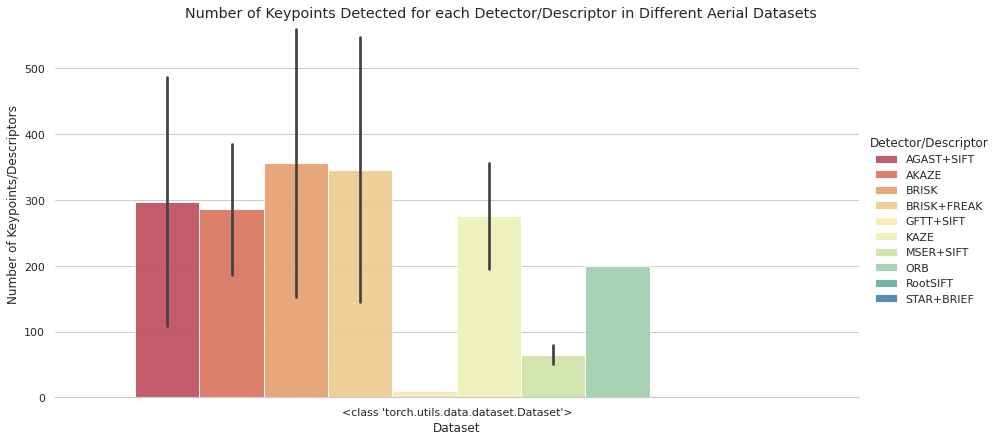

In [199]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [201]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_10_{Dataset}.csv')

In [204]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb   + num_matches_briefstar , 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1)  + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) + ['STAR+BRIEF']*(len_files-1)}
df = pd.DataFrame.from_dict(d, orient='index')
df_match_15 = df.transpose()

df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

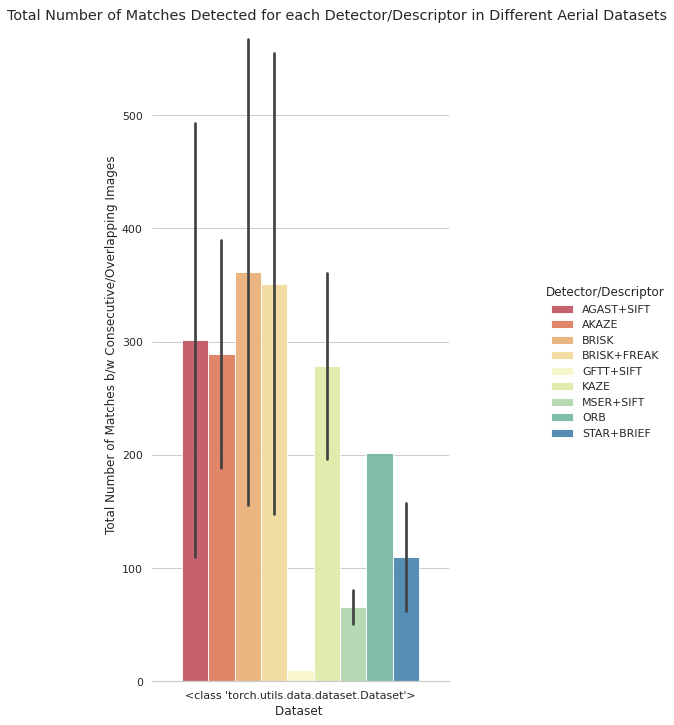

In [205]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [206]:
num_good_matches_mser = [0]*len(num_good_matches_agast)

In [207]:
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_freak + num_good_matches_gftt + num_good_matches_kaze + num_good_matches_mser + num_good_matches_orb  + num_good_matches_briefstar 
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)

ValueError: ignored

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']

In [210]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

ValueError: ignored

In [ ]:
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [212]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[0]] + [time_all[1]] + [time_all[2]] + [time_all[3]] + [time_all[4]] + [time_all[5]] + [time_all[6]] + [time_all[7]] + [time_all[8]] + [time_all[9]]   , 'Detector/Descriptor':['AGAST+SIFT'] + ['AKAZE'] + ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['GFTT+SIFT']*(1) + ['KAZE']*(1) + ['MSER+SIFT']*(1) + ['ORB']*(1)   + ['STAR+BRIEF']*(1)} 

df = pd.DataFrame.from_dict(d, orient='index')
df_time_15 = df.transpose()

In [213]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_15, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

TypeError: ignored